# Capstone Project
#### Summary
In this notebook I investigate whether categorising music based on language difficulty could be used to facilitate non-native language learning. I scraped song meta data on 50k songs from Spotify and corresponding lyrics from the QQ Music API. I applied a range of statistcal modelling techniques to the data as a practical application of the material covered on this course. 


## 1. Virtual Environment & Installing Packages

### 1.0 Virtual Environment

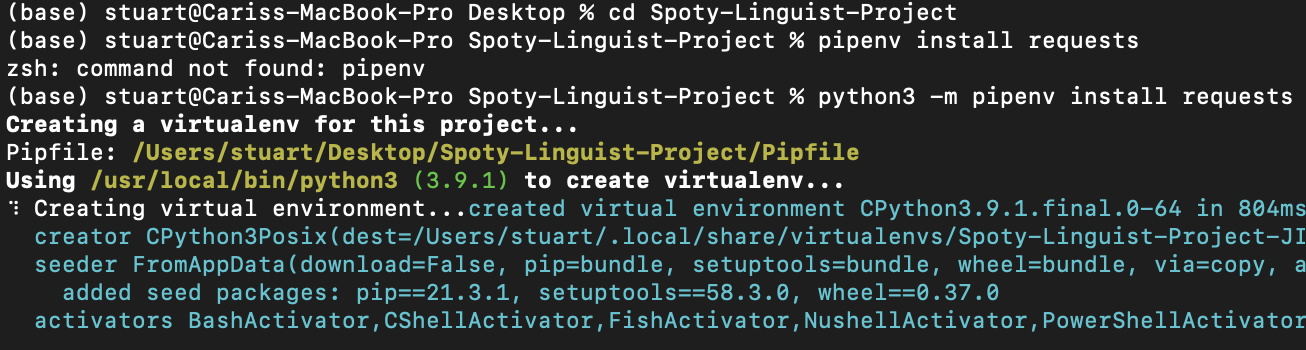

#### In terminal:
- Go to project directory and run: python3 -m venv env
- Note 'env' is name of sub folder where virtual environment will be located
- Activate the virtual environment: source env/bin/activate
- Confirm virtual environment is active by checking location of Python interpreter: source env/bin/activate
- It should be in the env directory
- To leave virtual environment: dactivate
- Set up new Kernel which uses env for packages: python3 -m ipykernel install --user --name=env
- Select env Kernel in Jupyter Interface

#### Activate virtual environment in terminal:

Note will see project name on left side of prompt:
((Spoty-Linguist-Project) ) (base) stuart@Cariss-MacBook-Pro Spoty-Linguist-Project % code goes here

Deactivate with: 'deactivate'

### 1.1 Packages

#### Install packages in virtual evironment in terminal and  import packages below

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from tqdm import tqdm
import re
import sqlite3
from pandas.io import sql
import joblib

# Display settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.options.display.max_columns = False

# QQ Music API Package
from QQMusicAPI import QQMusic

# Spotipy API Package
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

# Mandarin NLP packages
from snownlp import SnowNLP
import jieba.posseg as pseg
import jieba
import hanzidentifier
import stopwordsiso
from stopwordsiso import stopwords

# NLP Using a count vectorizer TfidfVectorizer.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# disable warnings to increase readability of notebook
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# other
import ipywidgets as widgets

## 2. Data Collection

### 2.1. Spotify API Setup

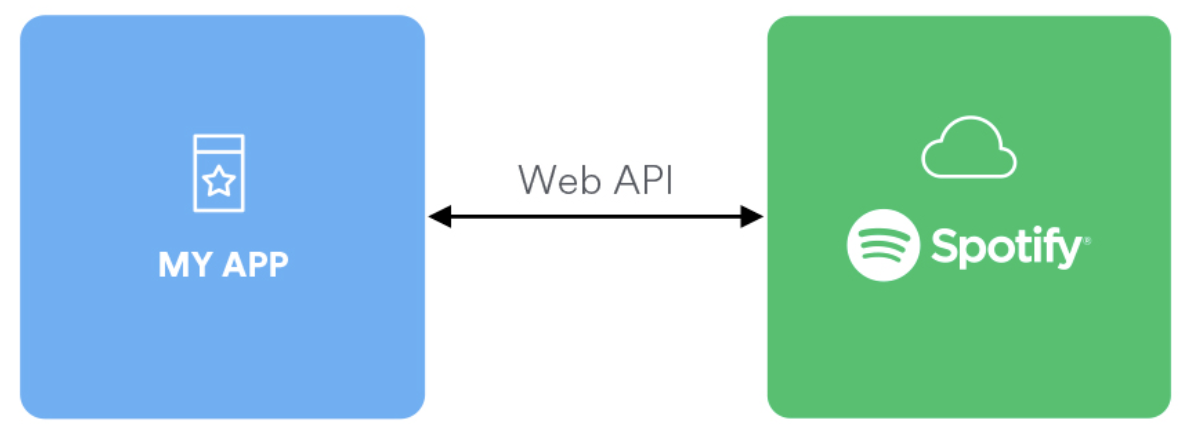

In [ ]:
# slmsn Log in to spotipy API
client_id = 'c66cb687e0e84683a4e3ab8e8e434fb4'
client_secret = 'afcc61af42db4850a39bae2f80c7d22c'
spotipy_redirect = 'http://127.0.0.1:8888/'
username = 'stoooey'
device_id = '0d4063631663fbfd1c65bab8abb4d4cdd29a7ee3'
# # slout Log in to spotipy API
# client_id = 'd4326d78b2d546748e38e64999553ed7'
# client_secret = '322745c5243e4c20ac0f70c9e9f64aad'
# spotipy_redirect = 'http://127.0.0.1:8082/'
# username = '31vdm4nfavfv5cxazcd2agrhcxi4'
# device_id = '129053ff24523dd666330f953596e609249aad14'

scope = 'playlist-modify-private,playlist-modify-public,user-library-read,user-top-read,streaming, user-read-playback-state, user-read-recently-played'

token = SpotifyOAuth(username=username,
                     scope=scope,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=spotipy_redirect)
sp = spotipy.Spotify(auth_manager=token, requests_timeout=10, retries=10)

In [ ]:
# sp can then be used to access spotify API commands

In [ ]:
sp.artist_top_tracks('spotify:artist:7fIvjotigTGWqjIz6EP1i4')

In [ ]:
# # E.g. access current user (me) most recently played song
sp.current_user_recently_played()

### 2.2. Scrape mandarin speaking artists from Spotify
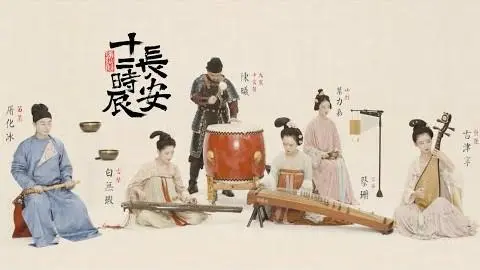

I started with a playlist of 100 mandarin songs. I then found similar artists using the Spotify API's related artists function to find further artists. I repeated this process on each of the new artists that I found until I had c.2,000 artists. I could have scraped many more artists however I was limited by the number of requests I could send to the Spotify server and time available. The artists scraped were more than sufficient for the purposes on this project. 

_Footnote: In the below example code I use a starting playlist of just 3 tracks to reduce run time in this notebook. The full results were run previously and are imported at the end of this section._

In [ ]:
# I created a playlist in Spotify of 100 songs by various mandarin artists
# The below functions import the playlist and saves information about each track
# Including track name, artist, artist code,
# Playlist url is available in spotify (share playlist)


# Function to get the individual ids of each song in a playlist
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids


# Function to return information about a single track from its Spotify ID
def getTrackFeatures(id):
    try:
        meta = sp.track(id)
        features = sp.audio_features(id)
        name = meta['name']
        artist_href = meta['album']['artists'][0]['href']
        artist = meta['album']['artists'][0]['name']
        artist_uri = meta['artists'][0]['uri']
        artist_type = meta['artists'][0]['type']
        song_available_markets = meta['available_markets']
        song_duration_ms = meta['duration_ms']
        is_explicit = meta['explicit']
        song_href = meta['href']
        preview_url = meta['preview_url']
        track_number = meta['track_number']
        song_type = meta['type']
        length = meta['duration_ms']
        popularity = meta['popularity']
        album = meta['album']['name']
        album_type = meta['album']['album_type']
        album_artwork_link = meta['album']['images'][0]['url']
        album_tracks_num = meta['album']['total_tracks']
        album_uri = meta['album']['uri']
        album_release_date = meta['album']['release_date']
        acousticness = features[0]['acousticness']
        danceability = features[0]['danceability']
        energy = features[0]['energy']
        instrumentalness = features[0]['instrumentalness']
        liveness = features[0]['liveness']
        loudness = features[0]['loudness']
        speechiness = features[0]['speechiness']
        tempo = features[0]['tempo']
        time_signature = features[0]['time_signature']
        track = [
            name, artist_href, artist, artist_uri, artist_type,
            song_available_markets, song_duration_ms, is_explicit, song_href,
            preview_url, track_number, song_type, length, popularity, album,
            album_type, album_artwork_link, album_tracks_num, album_uri,
            album_release_date, acousticness, danceability, energy,
            instrumentalness, liveness, loudness, speechiness, tempo,
            time_signature
        ]
        return track
    except:
        pass


# Function to save information on every song in playlist in a dataframe
# This uses the two functions above
def grab_song_from_playlist(playlisturl, choose_playlist_name):
    # Spotify developer login credentials for API
    ids = getTrackIDs(username, playlisturl)
    tracks = []
    for i in range(len(ids)):
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    # create dataset and save as csv
    df = pd.DataFrame(
        tracks,
        columns=[
            'name', 'artist_href', 'artist', 'artist_uri', 'artist_type',
            'song_available_markets', 'song_duration_ms', 'is_explicit',
            'song_href', 'preview_url', 'track_number', 'song_type', 'length',
            'popularity', 'album', 'album_type', 'album_artwork_link',
            'album_tracks_num', 'album_uri', 'album_release_date',
            'acousticness', 'danceability', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'
        ])
    df.to_csv("%s.csv" % choose_playlist_name, sep=',')
    return df

In [ ]:
df_eg_playlist = grab_song_from_playlist(
    'spotify:playlist:3MfiGKuLbufkFtBfKOSkA0', 'Example_playlist')
df_eg_playlist

Songs and their meta data are saved from the playlist and shown in the above dataframe. This dataframe was then used as a starting point to find further artists.


In [ ]:
# Function to find similar artists to those included in original playlist
def scrape_similar_artists(starter_artist):
    # 1 Scrape similar artists and create df

    request = sp.artist_related_artists(starter_artist)
    name = []
    genres = []
    popularity = []
    followers = []
    artist_id = []
    artist_uri = []
    artist_href = []
    artist_images = []

    for ind, artists in enumerate(request['artists']):
        name.append(request['artists'][ind]['name'])
        genres.append(','.join(request['artists'][ind]['genres']))
        popularity.append(request['artists'][ind]['popularity'])
        followers.append(request['artists'][ind]['followers']['total'])
        artist_id.append(request['artists'][ind]['id'])
        artist_uri.append(request['artists'][ind]['uri'])
        artist_href.append(request['artists'][ind]['href'])
        # artist_images.append(request['artists'][ind]['images'][0]['url'])
        artist_images.append(np.nan)
    data = [
        name, genres, popularity, followers, artist_id, artist_uri,
        artist_href, artist_images
    ]
    df_artists = pd.DataFrame(data).T
    df_artists.columns = columns = [
        'name', 'genres', 'popularity', 'followers', 'artist_id', 'artist_uri',
        'artist_href', 'artist_images'
    ]
    df_artists = df_artists.sort_values(by='popularity', ascending=False)
    return df_artists

In [ ]:
# For each artist scrape similar artists and save the artist details in a new dataframe
df_eg_playlist_similar_artists = pd.DataFrame()
for ind, i in enumerate(df_eg_playlist['artist_uri']):
    try:
        df_eg_playlist_similar_artists = df_eg_playlist_similar_artists.append(
            scrape_similar_artists(i))
    except:
        pass

df_eg_playlist_similar_artists = df_eg_playlist_similar_artists.drop_duplicates(
    subset='artist_id', keep="last")

In [ ]:
df_eg_playlist_similar_artists.head(5)

In [ ]:
df_eg_playlist_similar_artists.shape

In this example the origial playlist has been expanded from an inital number of 3 artists/tracks to 48 artists. I then used this to expand the search further by again looking for similar artists. For each new artist found I look for more similar artists.

In [ ]:
# Function to expand this search further.
# Takes data frame of artists made above and looks for similar artists
# It then looks for similar artists to those new artists found and so on
# Each sub tree is searched until no new artists are available
def scrape_similar_artists_expansion(df_artists):
    # for each of the similar artists found scrape similar artists of these too and repeat and until no more unique searches
    # use input df as master df
    master_df = df_artists
    searched_already_list = []
    count = 0
    artist_dict = {}
    for ind, uri in enumerate(master_df['artist_uri']):
        if count < 10000:
            count += 1
            if uri not in searched_already_list:
                artist_dict[ind] = scrape_similar_artists(uri)
                searched_already_list.append(uri)
    for i in artist_dict.keys():
        master_df = master_df.append(artist_dict[i])
    master_df = master_df.drop_duplicates(subset='artist_id', keep="last")
    master_df = master_df.sort_values(by='popularity', ascending=False)
    return master_df

In [ ]:
# # Run the code:
# df_eg_playlist_similar_artists_expand = scrape_similar_artists_expansion(df_eg_playlist_similar_artists)

Running all of the code from this section (3) resulted in a list of c. 2,000 mandarin speaking artists.

In [ ]:
artists_df = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/Old Dfs/artists_df.csv',
    sep=',',
    index_col=0)
artists_df.head()

In [ ]:
artists_df.shape

### 2.3. Get a list of albums for the artists scraped in 2.2.

In [ ]:
# Loop through all of the artists scraped in 3.0 and get a list of albums
# Here we run through only the first 2 artists as an example
empty_list_albums = []

for artist_uri in tqdm(artists_df['artist_uri'].iloc[:2]):
    album_uri_temp = sp.artist_albums(artist_uri)
    for ind, i in enumerate(album_uri_temp['items']):
        empty_list_albums.append(album_uri_temp['items'][ind]['uri'])

### 2.4. Get songs and meta data for each album

In [ ]:
# loop through all the albums and get track ids for each (top 2 only here)
empty_list_tracks3 = []
for album in tqdm(empty_list_albums[:2]):
    temp = sp.album_tracks(album)['items']
    for ind, track in enumerate(temp):
        try:
            empty_list_tracks3.append(
                sp.album_tracks(album)['items'][ind]['uri'])
        except:
            pass

In [ ]:
# Function to get song information from list of song ids
# This didnt work well with large dataframes
# def grab_song_from_ids(ids, choose_playlist_name):
#     # Spotify developer login credentials for API
#     sp = spotify_api_login()

#     tracks = []
#     for i in range(len(ids)):
#         # time.sleep(.5)
#         track = getTrackFeatures(ids[i])
#         tracks.append(track)

#     # create dataset
#     df = pd.DataFrame(tracks, columns = ['name', 'artist_href', 'artist','artist_uri','artist_type','song_available_markets','song_duration_ms','is_explicit','song_href','preview_url', 'track_number', 'song_type', 'length', 'popularity', 'album', 'album_type','album_artwork_link', 'album_tracks_num', 'album_uri', 'album_release_date', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
#     df.to_csv("%s.csv"%choose_playlist_name, sep = ',')
#     return df

In [ ]:
# Loop through list of track IDs and get song information
tracks = []
for i in tqdm(empty_list_tracks3):
    try:
        track = getTrackFeatures(i)
        tracks.append(track)
    except:
        pass

In [ ]:
# Loop through list of tracks and append to dataframe. Note that couldnt add altogether due to
# size issues.
df_tracks_master = pd.DataFrame(columns=[
    'name', 'artist_href', 'artist', 'artist_uri', 'artist_type',
    'song_available_markets', 'song_duration_ms', 'is_explicit', 'song_href',
    'preview_url', 'track_number', 'song_type', 'length', 'popularity',
    'album', 'album_type', 'album_artwork_link', 'album_tracks_num',
    'album_uri', 'album_release_date', 'acousticness', 'danceability',
    'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'time_signature'
])

for ind, i in enumerate(tracks):
    try:
        df_tracks_master.loc[ind] = i
    except:
        pass

Here's one I made earlier: the full dataframe of all tracks scraped

In [ ]:
df_tracks_master = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/Old Dfs/df_tracks_master.csv',
    sep=',',
    index_col=0)
display(df_tracks_master.head())
df_tracks_master.shape

Clean up the data:

In [ ]:
# Update column data types
strings_cols = [
    'name', 'artist_href', 'artist', 'artist_uri', 'artist_type',
    'song_available_markets', 'song_duration_ms', 'is_explicit', 'song_href',
    'preview_url', 'song_type', 'album', 'album_type', 'album_artwork_link',
    'album_uri'
]

for i in strings_cols:
    df_tracks_master[i] = df_tracks_master[i].astype("string")
df_tracks_master['album_release_date'] = pd.to_datetime(
    df_tracks_master.album_release_date)

df_tracks_master.dtypes

In [ ]:
# Drop NAs
df_tracks_master_clean = df_tracks_master.dropna()
df_tracks_master_clean.shape

In [ ]:
df_tracks_master_clean = df_tracks_master.drop_duplicates(subset='name',
                                                          keep='first')
df_tracks_master_clean.shape

In [ ]:
df_tracks_master_clean = df_tracks_master_clean.drop_duplicates(
    subset=['acousticness', 'danceability', 'energy', 'tempo'], keep='first')
df_tracks_master_clean.shape

In [ ]:
# Save the CSV to drive
df_tracks_master_clean.to_csv('df_tracks_master_clean.csv')

## 3. Lyric Scraping and Some SQL

### 3.1. Lyrics Scraper
.  |  .
- | - 
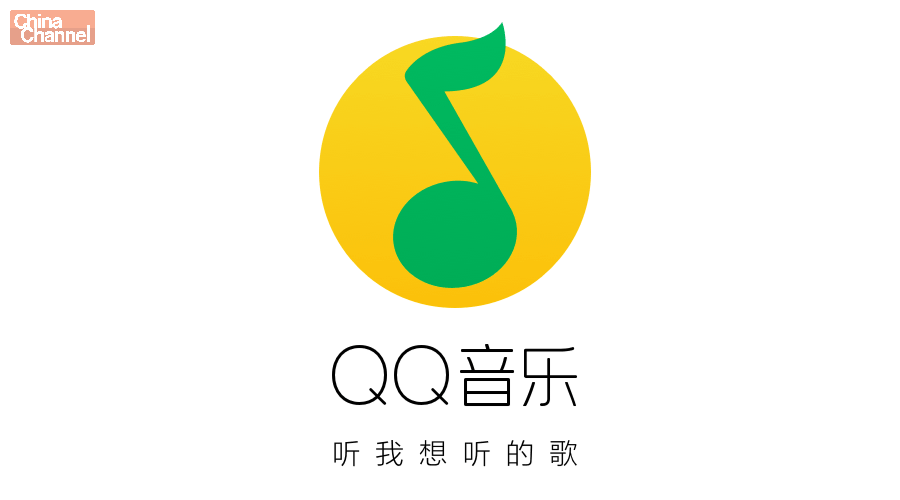| 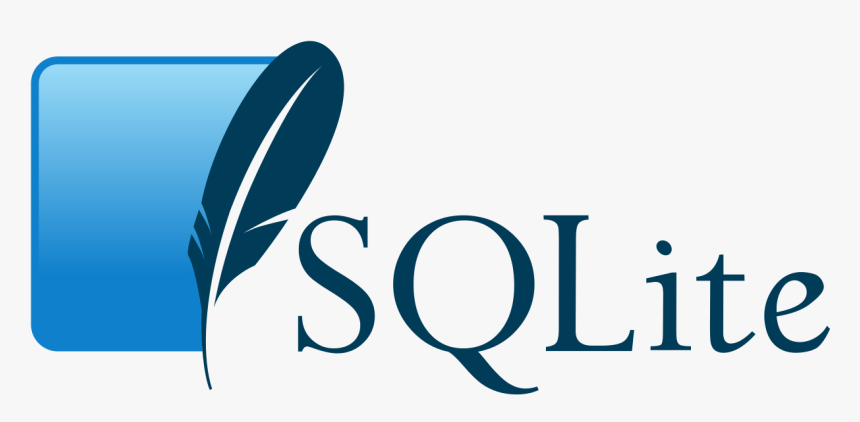 

I used the QQ Music API to scrape lyrics for each of the songs I scraped in section 2. This was the most time consuming part of the project with the scraper running for more than 4 days. Surprisingly a majority of the songs I scraped had lyrics available. I encountered issues with the dataframe size becoming too large which was solved by using an SQL database to store information. Lyrics were downloaded in string format with time stamps generally included. I used regex to filter this information. As well as saving the primary dataframe (Spotify song information + lyrics) in SQL, I also saved each song in a unique table with the lyrics in one column and the time stamps in another. I found that I could use this later to print the lyrics of a song in time with the music (just for fun!).

I scraped lyrics for ~55,000 songs. The code below is blocked so that the scraper doesn't run again.

In [ ]:
# import random
# db_connection = sqlite3.connect('/Users/stuart/Desktop/Spoty-Linguist-Project/master_sql_db.db.sqlite')
# # Regex for extracting lyrics and time stamps fro QQ scrape
# lyric_r = re.compile(r'\[\d\d\:\d\d\.\d\d\](\w+|'')')
# time_r = re.compile(r'\[(\d\d\:\d\d\.\d\d)\]')

# df = df_tracks_master_clean.copy()
# df['lyrics'] = 'nan'
# df['time_stamp'] = 'nan'

# for ind, i in tqdm(enumerate(df.name)):

#     # create search string:
#     if df.artist.iloc[ind] == 'Various Artists': # if Various artist, just search for album and song name
#         search_text = df.name.iloc[ind] + " " + df.album.iloc[ind]
#     else:
#         search_text = df.artist.iloc[ind] + " " + df.name.iloc[ind]
#     try:
#         search_result = QQMusic.search(search_text).data[0]
#         lyric = search_result.lyric
#         lyric.extract()
#         lyric = lyric.lyric

#         # add lyrics and timestamps to main dataframe
#         lyric_list = re.findall(lyric_r, lyric)
#         time_list = re.findall(time_r, lyric)
#         lyric_string = ','.join(lyric_list)
#         lyric_time = ','.join(time_list)
#         df.iloc[ind,29] = lyric_string
#         df.iloc[ind, 30] = lyric_time

#         if not lyric_list:
#             df.iloc[ind,29] = lyric
# #         # save to csv
# #         df.to_csv('df_tracks_master_lyrics.csv')
# # save to sql:
#         df.to_sql(name = 'master', con = db_connection, if_exists = 'replace', index = False)

#     except:
#         pass

#     try:
#         # create a dataframe for each song and save in sql
#         df_temp = pd.DataFrame({'time':time_list,'lyrics':lyric_list})
#         name_temp = df.iloc[ind,0]
#         df_temp.to_sql(name = name_temp, con = db_connection, if_exists = 'replace', index = False)
#     except:
#         pass

#     time.sleep(random.uniform(1,4))

In [ ]:
# Import the results from the final dataframe table in SQL
db_connection = sqlite3.connect(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/master_sql_db.db.sqlite')
df_tracks_master_clean_lyrics = sql.read_sql('SELECT * FROM master',
                                             con=db_connection)
df_tracks_master_clean_lyrics.shape

### 3.2. Add Genre of songs (from Spotify)

In [ ]:
df_tracks_master_clean_lyrics_genre = df_tracks_master_clean_lyrics.merge(
    artists_df[['artist_uri',
                'genres']], on='artist_uri', how='left').drop_duplicates()
df_tracks_master_clean_lyrics_genre.to_csv(
    'df_tracks_master_clean_lyrics_genre.csv')

In [ ]:
def add_genre_0(genre_0):
    try:
        genre_reg = re.compile(r'\w+')
        genre_list = re.findall(genre_reg, genre_0)
        return genre_list[0]
    except:
        return np.nan


def add_genre_1(genre_1):
    try:
        genre_reg = re.compile(r'\w+')
        genre_list = re.findall(genre_reg, genre_1)
        return genre_list[1]
    except:
        return np.nan


def add_genre_2(genre_2):
    try:
        genre_reg = re.compile(r'\w+')
        genre_list = re.findall(genre_reg, genre_2)
        return genre_list[2]
    except:
        return np.nan

In [ ]:
df_tracks_master_clean_lyrics_genre[
    'genre_0'] = df_tracks_master_clean_lyrics_genre['genres'].apply(
        add_genre_0)
df_tracks_master_clean_lyrics_genre[
    'genre_1'] = df_tracks_master_clean_lyrics_genre['genres'].apply(
        add_genre_1)
df_tracks_master_clean_lyrics_genre[
    'genre_2'] = df_tracks_master_clean_lyrics_genre['genres'].apply(
        add_genre_2)

In [ ]:
df_tracks_master_clean_lyrics_genre['genre_0'].isnull().sum()

In [ ]:
df_tracks_master_clean_lyrics_genre.to_csv(
    'df_tracks_master_clean_lyrics_genre')

In [ ]:
df_tracks_master_clean_lyrics_genre = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean_lyrics_genre.csv',
    sep=',',
    index_col=0)

At this stage 768 lyrics are null. None of the artists are null. 

## 4. Language Difficulty Scoring

#### 4.1. HSK Scores
Many people studying mandarin will follow the HSK testing system. In this system the language learning process is divided into 6 grades (HSK 1 to HSK 6). In each stage the amount of characters /words a student is required to recognise increases:

- HSK1: 300 characters / 500 words
- HSK2: 600 characters / 1300 words
- HSK3: 900 characters / 2300 words
- HSK4: 1200 characters / 3300 words
- HSK5: 1500 characters / 4300 words
- HSK6 1800 characters / 5500 words

Using this system I gave each song a score for each HSK level to show what percentage of the lyrics would be known by a person at that level. I utilised CSV files of mandarin vocab at each HSK level。

Chinese words can be made of one or more characters. For example 'I' is formed by one character 我, where as library is formed by 3 character 图书馆. I therefore  used 'SnowNLP' a mandarin NLP Python package to tokenise the lyrics.

In [ ]:
# SnowNLP example:
print('I met my friends in the library')
print('我在图书馆遇到了我的朋友')
SnowNLP(u'我在图书馆遇到了我的朋友').words

In [ ]:
# Import HSK Lists: CSV files with words at each HSK level
csv_file_hsk1 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk1.csv"
hsk1 = pd.read_csv(csv_file_hsk1, sep=',', header=None)
hsk1.columns = ['mandarin', 'pinyin', 'english']

csv_file_hsk2 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk2.csv"
hsk2 = pd.read_csv(csv_file_hsk2, sep=',', header=None)
hsk2.columns = ['mandarin', 'pinyin', 'english']

csv_file_hsk3 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk3.csv"
hsk3 = pd.read_csv(csv_file_hsk3, sep=',', header=None)
hsk3.columns = ['mandarin', 'pinyin', 'english']

csv_file_hsk4 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk4.csv"
hsk4 = pd.read_csv(csv_file_hsk4, sep=',', header=None)
hsk4.columns = ['mandarin', 'pinyin', 'english']

csv_file_hsk5 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk5.csv"
hsk5 = pd.read_csv(csv_file_hsk5, sep=',', header=None)
hsk5.columns = ['mandarin', 'pinyin', 'english']

csv_file_hsk6 = "/Users/stuart/Desktop/GA2/DSI20-lessons/projects/project-capstone/SL1/hsk_csv-master/hsk6.csv"
hsk6 = pd.read_csv(csv_file_hsk6, sep=',', header=None)
hsk6.columns = ['mandarin', 'pinyin', 'english']

In [ ]:
# expand hsk lists to also include individual characters
def expand_hsk(x):
    elist = []
    for i in x.mandarin:
        for j in i:
            elist.append(j)
    temp = pd.DataFrame(elist).drop_duplicates()
    temp['pinyin'] = np.nan
    temp['english'] = np.nan
    temp.columns = ['mandarin', 'pinyin', 'english']
    x = x.merge(temp, how='outer', on='mandarin')
    x = x.drop(columns=['pinyin_y', 'english_y'])
    x.columns = ['mandarin', 'pinyin', 'english']
    return x


hsk1 = expand_hsk(hsk1)
hsk2 = expand_hsk(hsk2)
hsk3 = expand_hsk(hsk3)
hsk4 = expand_hsk(hsk4)
hsk5 = expand_hsk(hsk5)
hsk6 = expand_hsk(hsk6)

In [ ]:
# Create a column that labels each row as HSK level x
hsk1['hsk'] = 1
hsk2['hsk'] = 2
hsk3['hsk'] = 3
hsk4['hsk'] = 4
hsk5['hsk'] = 5
hsk6['hsk'] = 6

In [ ]:
# HSK1 should include all HSK1, HSK6 should include HSK1-HSK6
hsk2 = hsk2.append(hsk1)
hsk3 = hsk3.append(hsk2)
hsk4 = hsk4.append(hsk3)
hsk5 = hsk5.append(hsk4)
hsk6 = hsk6.append(hsk5)

In [ ]:
# Create a master HSK DF which includes all vocab and their HSK level
hsk6 = hsk6.sort_values(by='hsk')
hsk_master = hsk6.copy()

In [ ]:
# Drop any duplicates
hsk_master = hsk_master.drop_duplicates('mandarin')

In [ ]:
# Function take text and return df with HSK scores for each word or individual character:


def text_hsk_split(text):
    # tokenise the text: extract words (typically 1-2 characters)
    from snownlp import SnowNLP
    text = SnowNLP(text)
    lyrics_tokenised_df = pd.DataFrame(list(text.tags),
                                       columns=['mandarin', 'type'])
    # drop rows where there is only a comma and also drop duplicates:
    lyrics_tokenised_df = lyrics_tokenised_df[
        lyrics_tokenised_df["mandarin"].replace(
            ",", np.nan).notnull()].drop_duplicates()

    # add hsk levels to the df by left merging with HSK master df
    lyrics_tokenised_hsk_df = pd.merge(lyrics_tokenised_df,
                                       hsk_master,
                                       on="mandarin",
                                       how='left')

    # # for all nan values, break down into individual character and add to list
    lyrics_tokenised_hsk_nan_df = lyrics_tokenised_hsk_df[
        lyrics_tokenised_hsk_df['hsk'].isnull(
        )]  # filter for all that were hsk nan
    lyrics_tokenised_hsk_nan_df = lyrics_tokenised_hsk_nan_df[
        'mandarin'].str.extract(r'(\w)')  # extract indivual characters
    lyrics_tokenised_hsk_nan_df.columns = ['mandarin']
    lyrics_tokenised_hsk_nan_df = pd.merge(lyrics_tokenised_hsk_nan_df,
                                           hsk_master,
                                           on="mandarin",
                                           how='left')  # add hsk info
    lyrics_tokenised_hsk_nan_df = lyrics_tokenised_hsk_nan_df.drop_duplicates()
    lyrics_tokenised_hsk_not_nan_df = lyrics_tokenised_hsk_df[
        lyrics_tokenised_hsk_df['hsk'].notnull(
        )]  # filter original df for all that were not nan

    lyrics_tokenised_hsk_final_df = lyrics_tokenised_hsk_not_nan_df.append(
        lyrics_tokenised_hsk_nan_df)
    return lyrics_tokenised_hsk_final_df

In [ ]:
def check_hsk_levels(lyrics_tokenised_hsk_final_df):
    try:
        df = lyrics_tokenised_hsk_final_df.copy(
        )  # function to take df and return score

        hsk1_per = df[(df.hsk == 1)].shape[0] / df.hsk.shape[0]
        hsk2_per = df[(df.hsk == 2) | (df.hsk == 1)].shape[0] / df.hsk.shape[0]
        hsk3_per = df[(df.hsk == 3) | (df.hsk == 2) |
                      (df.hsk == 1)].shape[0] / df.hsk.shape[0]
        hsk4_per = df[(df.hsk == 4) | (df.hsk == 3) | (df.hsk == 2) |
                      (df.hsk == 1)].shape[0] / df.hsk.shape[0]
        hsk5_per = df[(df.hsk == 5) | (df.hsk == 4) | (df.hsk == 3) |
                      (df.hsk == 2) | (df.hsk == 1)].shape[0] / df.hsk.shape[0]
        hsk6_per = df[(df.hsk == 6) | (df.hsk == 5) | (df.hsk == 4) |
                      (df.hsk == 3) | (df.hsk == 2) |
                      (df.hsk == 1)].shape[0] / df.hsk.shape[0]
        results = [hsk1_per, hsk2_per, hsk3_per, hsk4_per, hsk5_per, hsk6_per]
        return results
    except:
        return [np.nan for i in range(6)]  # 6 nan values

In [ ]:
# Filter out any other non-chinese characters from the lyrics
def getChinese(context):
    filtrate = re.compile(u'[^\u4E00-\u9FA5]')  # non-Chinese unicode range
    context = filtrate.sub(r'', context)  # remove all non-Chinese characters
    return context

In [ ]:
# Filter out songs with less than 8 characters
df_tracks_master_clean2_lyrics__genre = df_tracks_master_clean_lyrics_genre.copy(
)
df_tracks_master_clean2_lyrics__genre[
    'lyrics'] = df_tracks_master_clean2_lyrics__genre['lyrics'].astype(str)
df_tracks_master_clean2_lyrics__genre[
    'lyrics'] = df_tracks_master_clean2_lyrics__genre['lyrics'].apply(
        getChinese)
df_tracks_master_clean2_lyrics__genre[
    'lyrics_len'] = df_tracks_master_clean2_lyrics__genre['lyrics'].apply(
        lambda x: len(x))
df_tracks_master_clean2_lyrics__genre = df_tracks_master_clean2_lyrics__genre[
    df_tracks_master_clean2_lyrics__genre['lyrics_len'] >= 8]

In [ ]:
df_tracks_master_clean2_lyrics__genre = df_tracks_master_clean2_lyrics__genre.drop_duplicates(
    'lyrics')

In [ ]:
df_tracks_master_clean2_lyrics__genre.shape

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk = df_tracks_master_clean2_lyrics__genre.copy(
)
# Run the above two functions into the main dataframe:
for ind, i in tqdm(enumerate(df_tracks_master_clean2_lyrics_genre_hsk.lyrics)):
    try:
        temp = text_hsk_split(i)
        temp = check_hsk_levels(temp)
    except:
        temp = [np.nan for i in range(6)]  # 6 nan values
        pass

    index_temp = df_tracks_master_clean2_lyrics_genre_hsk.index[ind]

    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk1'] = temp[0]
    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk2'] = temp[1]
    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk3'] = temp[2]
    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk4'] = temp[3]
    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk5'] = temp[4]
    df_tracks_master_clean2_lyrics_genre_hsk.loc[index_temp, 'hsk6'] = temp[5]

df_tracks_master_clean2_lyrics_genre_hsk = df_tracks_master_clean2_lyrics_genre_hsk.drop_duplicates(
    'name').copy()
df_tracks_master_clean2_lyrics_genre_hsk.to_csv(
    'df_tracks_master_clean2_lyrics_genre_hsk.csv')

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk.shape

In [ ]:
# Assign a HSK level to each song based on the vocabulary that is covered at that HSK level
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'] = 6
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk5'] >= 0.8] = 5
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk4'] >= 0.8] = 4
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk3'] >= 0.8] = 3
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk2'] >= 0.75] = 2
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk1'] >= 0.75] = 1

# Create binary classification for each song. E.g. is it suitable for HSK 2 learner at 80% coverage? Yes/ No
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_6_80p'] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_5_80p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_4_80p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_3_80p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_2_80p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_1_80p'] = 0

df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_5_80p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk5'] >= 0.8] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_4_80p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk4'] >= 0.8] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_3_80p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk3'] >= 0.8] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_2_80p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk2'] >= 0.8] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_1_80p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk1'] >= 0.8] = 1

df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_5_75p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_4_75p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_3_75p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_2_75p'] = 0
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_1_75p'] = 0

df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_5_75p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk5'] >= 0.75] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_4_75p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk4'] >= 0.75] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_3_75p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk3'] >= 0.75] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_2_75p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk2'] >= 0.75] = 1
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level_1_75p'][
    df_tracks_master_clean2_lyrics_genre_hsk['hsk1'] >= 0.75] = 1

display(df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'].value_counts(
    normalize=False))
df_tracks_master_clean2_lyrics_genre_hsk['hsk_level'].value_counts(
    normalize=True)

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk.to_csv(
    'df_tracks_master_clean2_lyrics_genre_hsk.csv')

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean2_lyrics_genre_hsk.csv',
    sep=',',
    index_col=0)
df_tracks_master_clean2_lyrics_genre_hsk.shape

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk.head()

## 5. Data Cleaning

Some final data cleaning including removing genres that are not in scope. Removal of corrupt lyrics etc.

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk[[
    'hsk1', 'hsk2', 'hsk3', 'hsk4', 'hsk5', 'hsk6'
]].describe()

In [ ]:
# delete as lyrics are corrupt
df_tracks_master_clean2_lyrics_genre_hsk = df_tracks_master_clean2_lyrics_genre_hsk.drop(
    index=[178755, 53570, 240, 84568])

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk[[
    'hsk1', 'hsk2', 'hsk3', 'hsk4', 'hsk5', 'hsk6'
]].describe()

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk['genre_0'][
    df_tracks_master_clean2_lyrics_genre_hsk.genre_0 == 'c'] = 'c-pop'

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk['genre_1'][
    df_tracks_master_clean2_lyrics_genre_hsk.genre_1 == 'r'] = 'chinese r&b'

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk['genre_1'][
    df_tracks_master_clean2_lyrics_genre_hsk['genre_1'] ==
    'viral'] = 'chinese_viral_pop'

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk[
    df_tracks_master_clean2_lyrics_genre_hsk['genre_0'].isnull()]

In [ ]:
sp.artist('potify:artist:2elBjNSdBE2Y3f0j1mjrql')

In [ ]:
list_of_artists = df_tracks_master_clean2_lyrics_genre_hsk.artist_uri.drop_duplicates(
)

In [ ]:
list_of_artists

Fix genres as previous work had too many errors:

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk_test = df_tracks_master_clean2_lyrics_genre_hsk.copy(
)

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk_test['Genre0']

In [ ]:
len(list_of_artists)

In [ ]:
artists_genre_df = pd.DataFrame()
for i in tqdm(list_of_artists):
    empty_list = []
    empty_list.append(i)
    genres_list = sp.artist(i)['genres']
    [empty_list.append(j) for j in genres_list]
    artists_genre_df = artists_genre_df.append([empty_list])
artists_genre_df

In [ ]:
artists_genre_df.columns = [
    'artist_uri', 'Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6',
    'Genre7'
]

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk = df_tracks_master_clean2_lyrics_genre_hsk.merge(
    artists_genre_df, on='artist_uri', how='left')

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk.to_csv(
    'df_tracks_master_clean2_lyrics_genre_hsk_v2.csv')

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean2_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1.value_counts()

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2 = df_tracks_master_clean2_lyrics_genre_hsk_v2[
    (df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1 != 'indian metal')
    & (df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1 != 'japanese piano')
    & (df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1 != 'danish pop') &
    (df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1 !=
     'english indie rock') &
    (df_tracks_master_clean2_lyrics_genre_hsk_v2.Genre1 != 'belgian dnb')]
df_tracks_master_clean3_lyrics_genre_hsk_v2 = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2 != 'russian dance pop')
    & (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2 !=
       'japanese punk rock') &
    (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2 != 'korean pop') &
    (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2 != 'japanese r&b')]
df_tracks_master_clean3_lyrics_genre_hsk_v2 = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre3 != 'nordic folk metal')
    & (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre3 !=
       'japanese jazz fusion')]

I also want to urls that can open the song in a browser rather than in the api. Update the api columns to allow this:

In [ ]:
def modify_url(x):
    url_search = re.compile(r'(?<=tracks).*')
    url_clean = 'https://open.spotify.com/track'
    url_clean = url_clean + re.findall(url_search, x)[0]
    return url_clean

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'weblink'] = df_tracks_master_clean3_lyrics_genre_hsk_v2['song_href']
df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'weblink'] = df_tracks_master_clean3_lyrics_genre_hsk_v2['weblink'].apply(
        modify_url)
df_tracks_master_clean3_lyrics_genre_hsk_v2['weblink'][:10]

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'].value_counts(
    normalize=True)

I also want to urls that can open the song in a browser rather than in the api. Update the api columns to allow this:

In [ ]:
def modify_url(x):
    url_search = re.compile(r'(?<=tracks).*')
    url_clean = 'https://open.spotify.com/track'
    url_clean = url_clean + re.findall(url_search, x)[0]
    return url_clean

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'weblink'] = df_tracks_master_clean3_lyrics_genre_hsk_v2['song_href']
df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'weblink'] = df_tracks_master_clean3_lyrics_genre_hsk_v2['weblink'].apply(
        modify_url)
df_tracks_master_clean3_lyrics_genre_hsk_v2['weblink'][:10]

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2.to_csv(
    'df_tracks_master_clean3_lyrics_genre_hsk_v2.csv')

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

## 7. Data Analysis

### 7.1. HSK Coverage
The KDE plots below demonstrate the distribution of song comprehension for each HSK level. At the lowest HSK levels 1 and 2 comprehension is low with HSK 1 / HSK 2 vocabulary covering on average 30% / 46% of lyrics in a song respectively. There are very few songs that are accessible at an 80% comprehension level (HSK 1: total of 4 songs, HSK 2: 32 songs). Nonethless, these outliers could be valuable to learners at this level where accessible authentic material is extremely limited.

Of course comprehension rates increase with HSK level and therefore the number of songs available at an 80% comprehenion increases too. At HSK 3 the number of songs available at 80% comprehension spikes to over 1000+ and at HSK 4 to 13,000+ and finally to 34,000+ for both HSK 5 and 6. This shows that even at HSK 3 and HSK 4 levels there is a large corpus of music that should be accessible to learners.

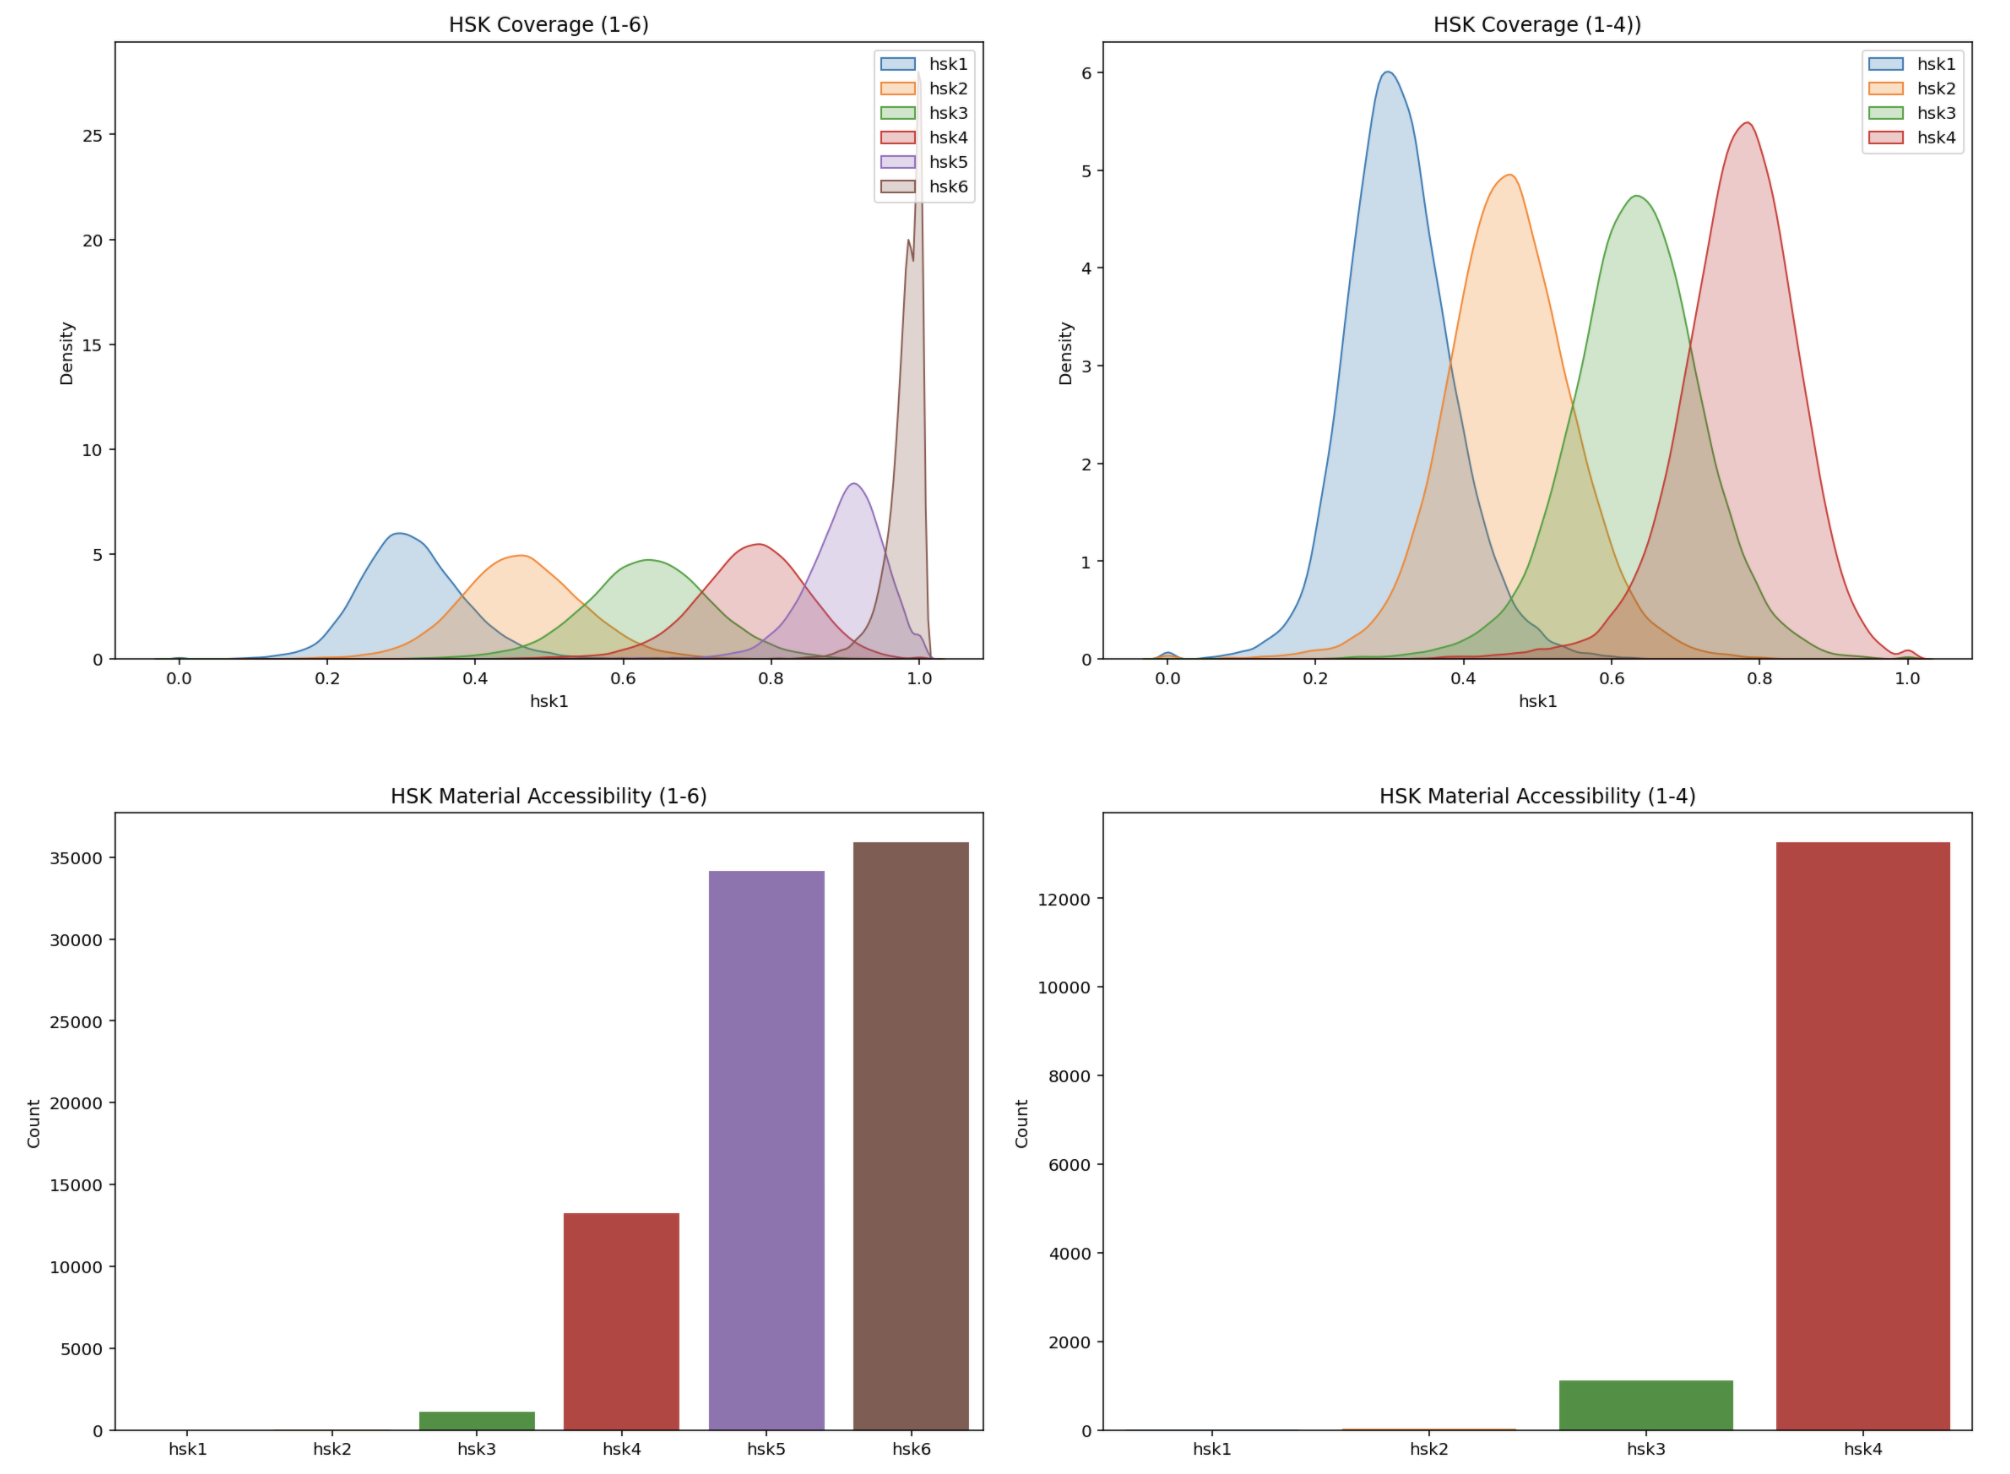

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
# Create a dataframe with the number of songs available at each HSK Level assuming 80% coverage
hsk6_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_6_80p'].sum()
hsk5_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_5_80p'].sum()
hsk4_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_4_80p'].sum()
hsk3_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_3_80p'].sum()
hsk2_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_2_80p'].sum()
hsk1_count = df_tracks_master_clean3_lyrics_genre_hsk_v2[
    'hsk_level_1_80p'].sum()

hsk_count_df = pd.DataFrame(
    [hsk6_count, hsk5_count, hsk4_count, hsk3_count, hsk2_count, hsk1_count],
    index=['hsk6', 'hsk5', 'hsk4', 'hsk3', 'hsk2', 'hsk1'],
    columns=['Count'])
hsk_count_df = hsk_count_df.sort_values(by='Count')

# Plot the results
fig1, ax1 = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
fig1.tight_layout(h_pad=7, w_pad=4)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk1'],
            ax=ax1[0][0],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk2'],
            ax=ax1[0][0],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk3'],
            ax=ax1[0][0],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk4'],
            ax=ax1[0][0],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk5'],
            ax=ax1[0][0],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk6'],
            ax=ax1[0][0],
            fill=True)
ax1[0][0].legend(['hsk1', 'hsk2', 'hsk3', 'hsk4', 'hsk5', 'hsk6'])
ax1[0][0].set_title('HSK Coverage (1-6)')

sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk1'],
            ax=ax1[0][1],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk2'],
            ax=ax1[0][1],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk3'],
            ax=ax1[0][1],
            fill=True)
sns.kdeplot(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk4'],
            ax=ax1[0][1],
            fill=True)
ax1[0][1].legend(['hsk1', 'hsk2', 'hsk3', 'hsk4'])
ax1[0][1].set_title('HSK Coverage (1-4))')

sns.barplot(data=hsk_count_df, x=hsk_count_df.index, y='Count', ax=ax1[1][0])
sns.barplot(data=hsk_count_df.iloc[:4],
            x=hsk_count_df.iloc[:4].index,
            y='Count',
            ax=ax1[1][1])

ax1[1][0].set_title('HSK Material Accessibility (1-6)')
ax1[1][1].set_title('HSK Material Accessibility (1-4)')
fig1.show()

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2[[
    'hsk1', 'hsk2', 'hsk3', 'hsk4', 'hsk5', 'hsk6'
]].describe()

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2.shape

### 7.2. Tableau
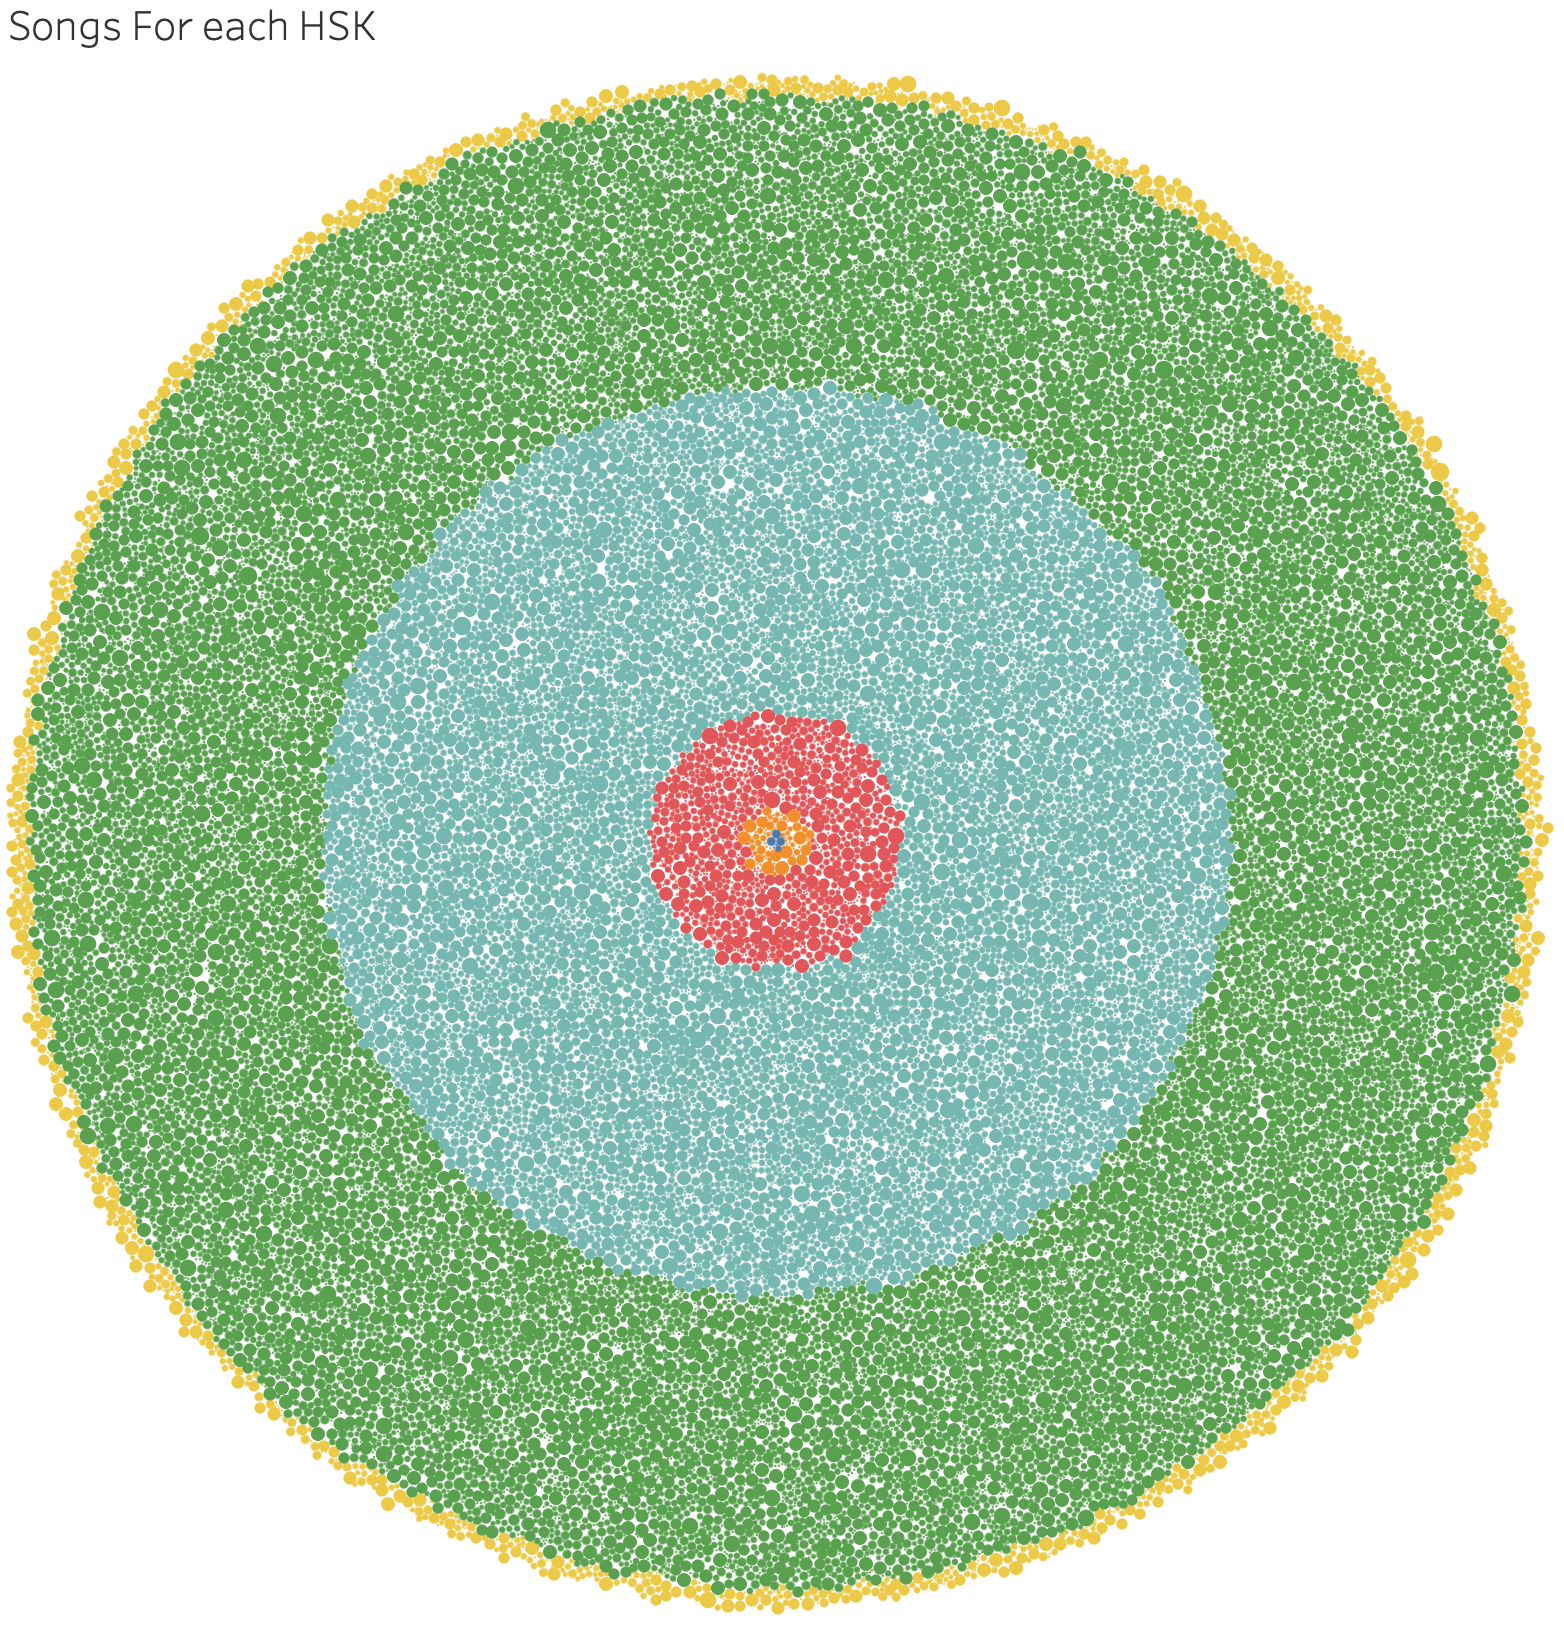
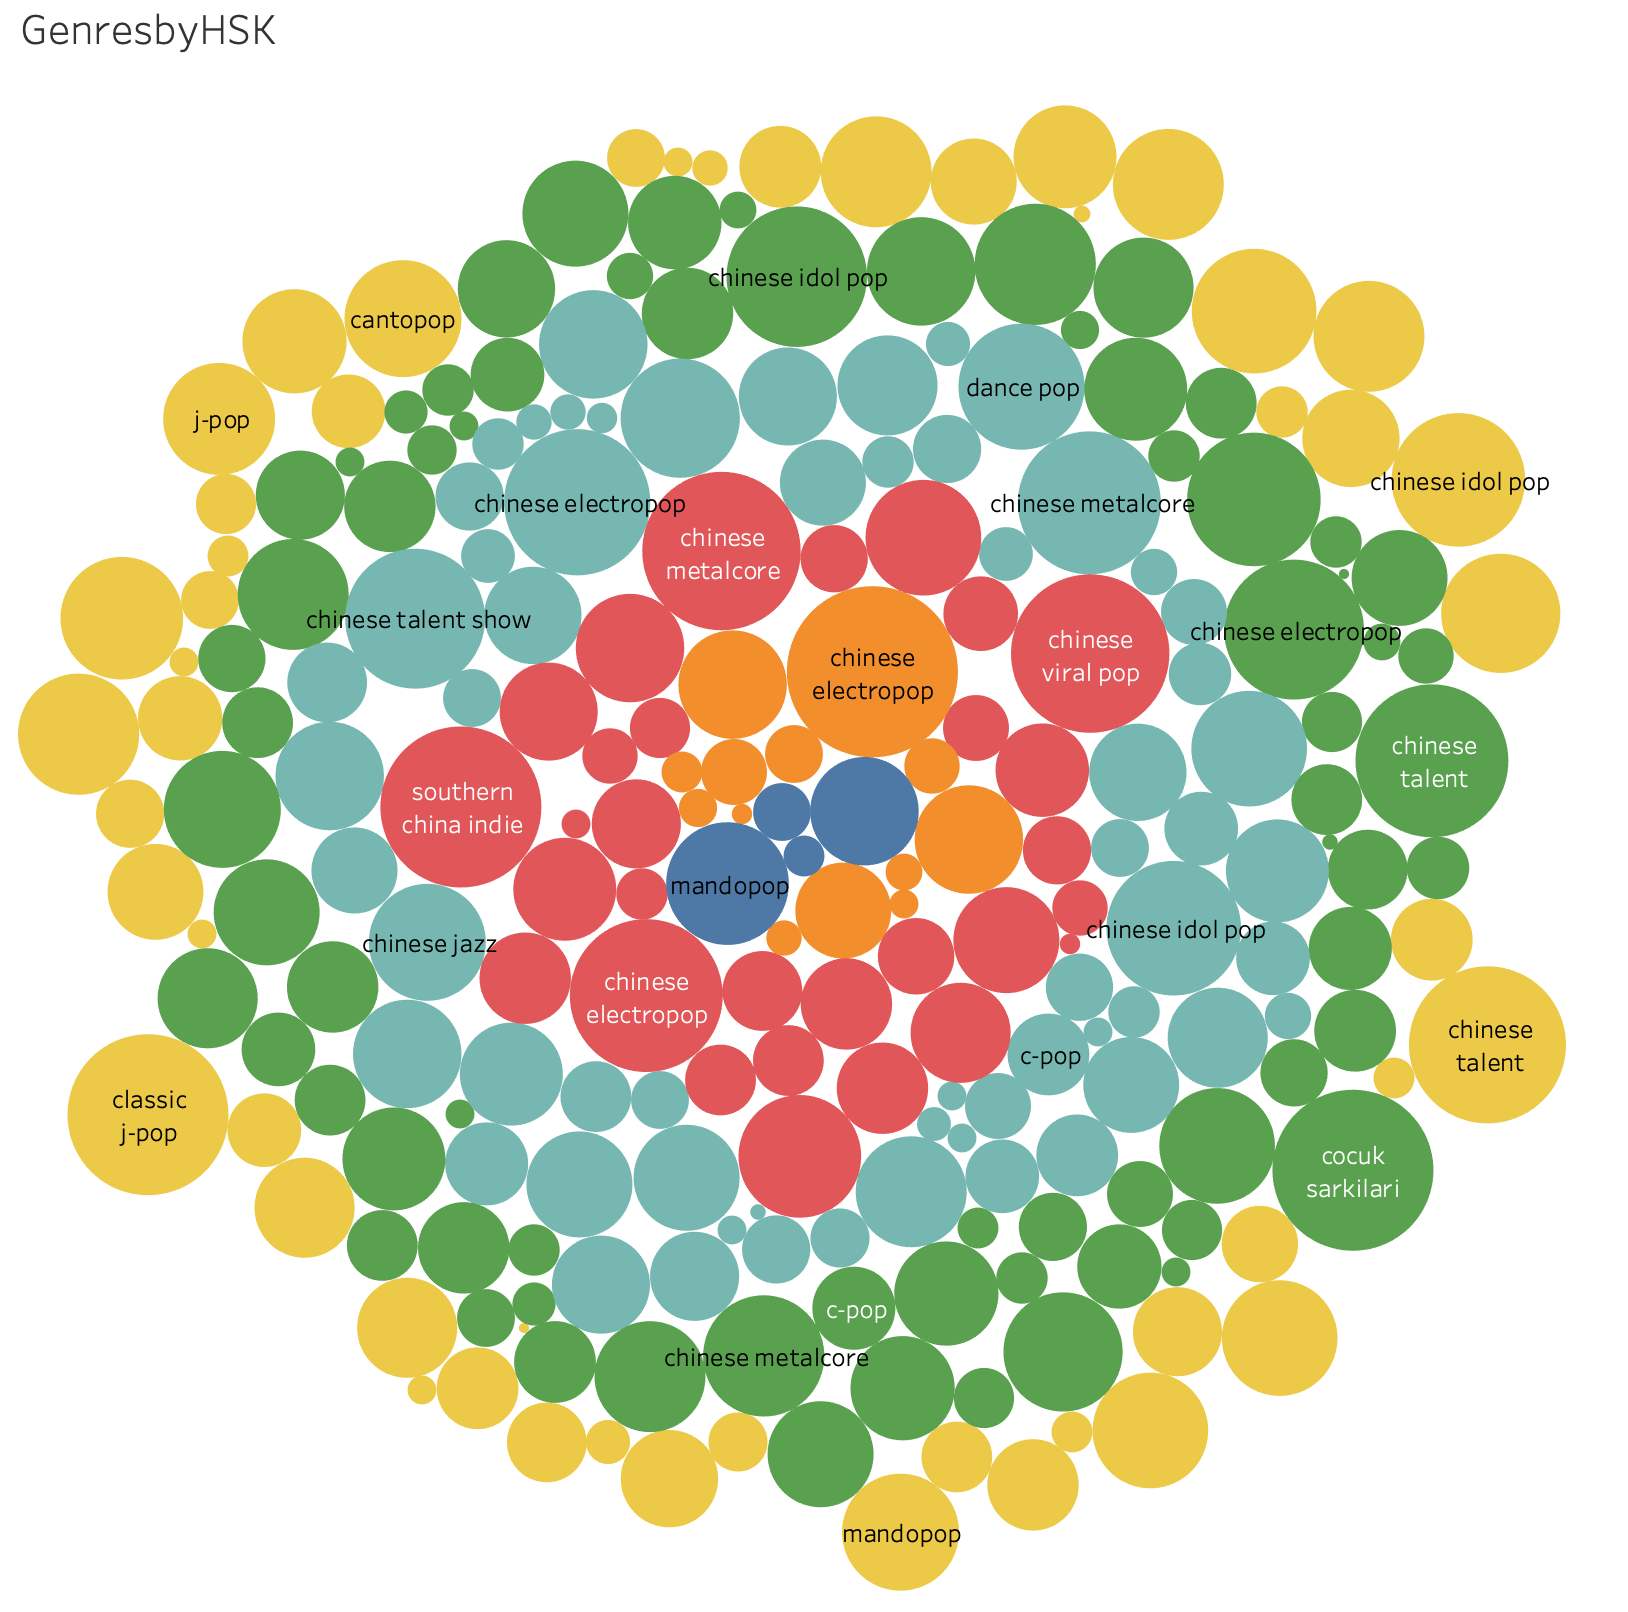

https://prod-uk-a.online.tableau.com/#/site/spottylinguist/workbooks/76696/views

### 7.3. Word Frequency Analysis
#### With stop words included:
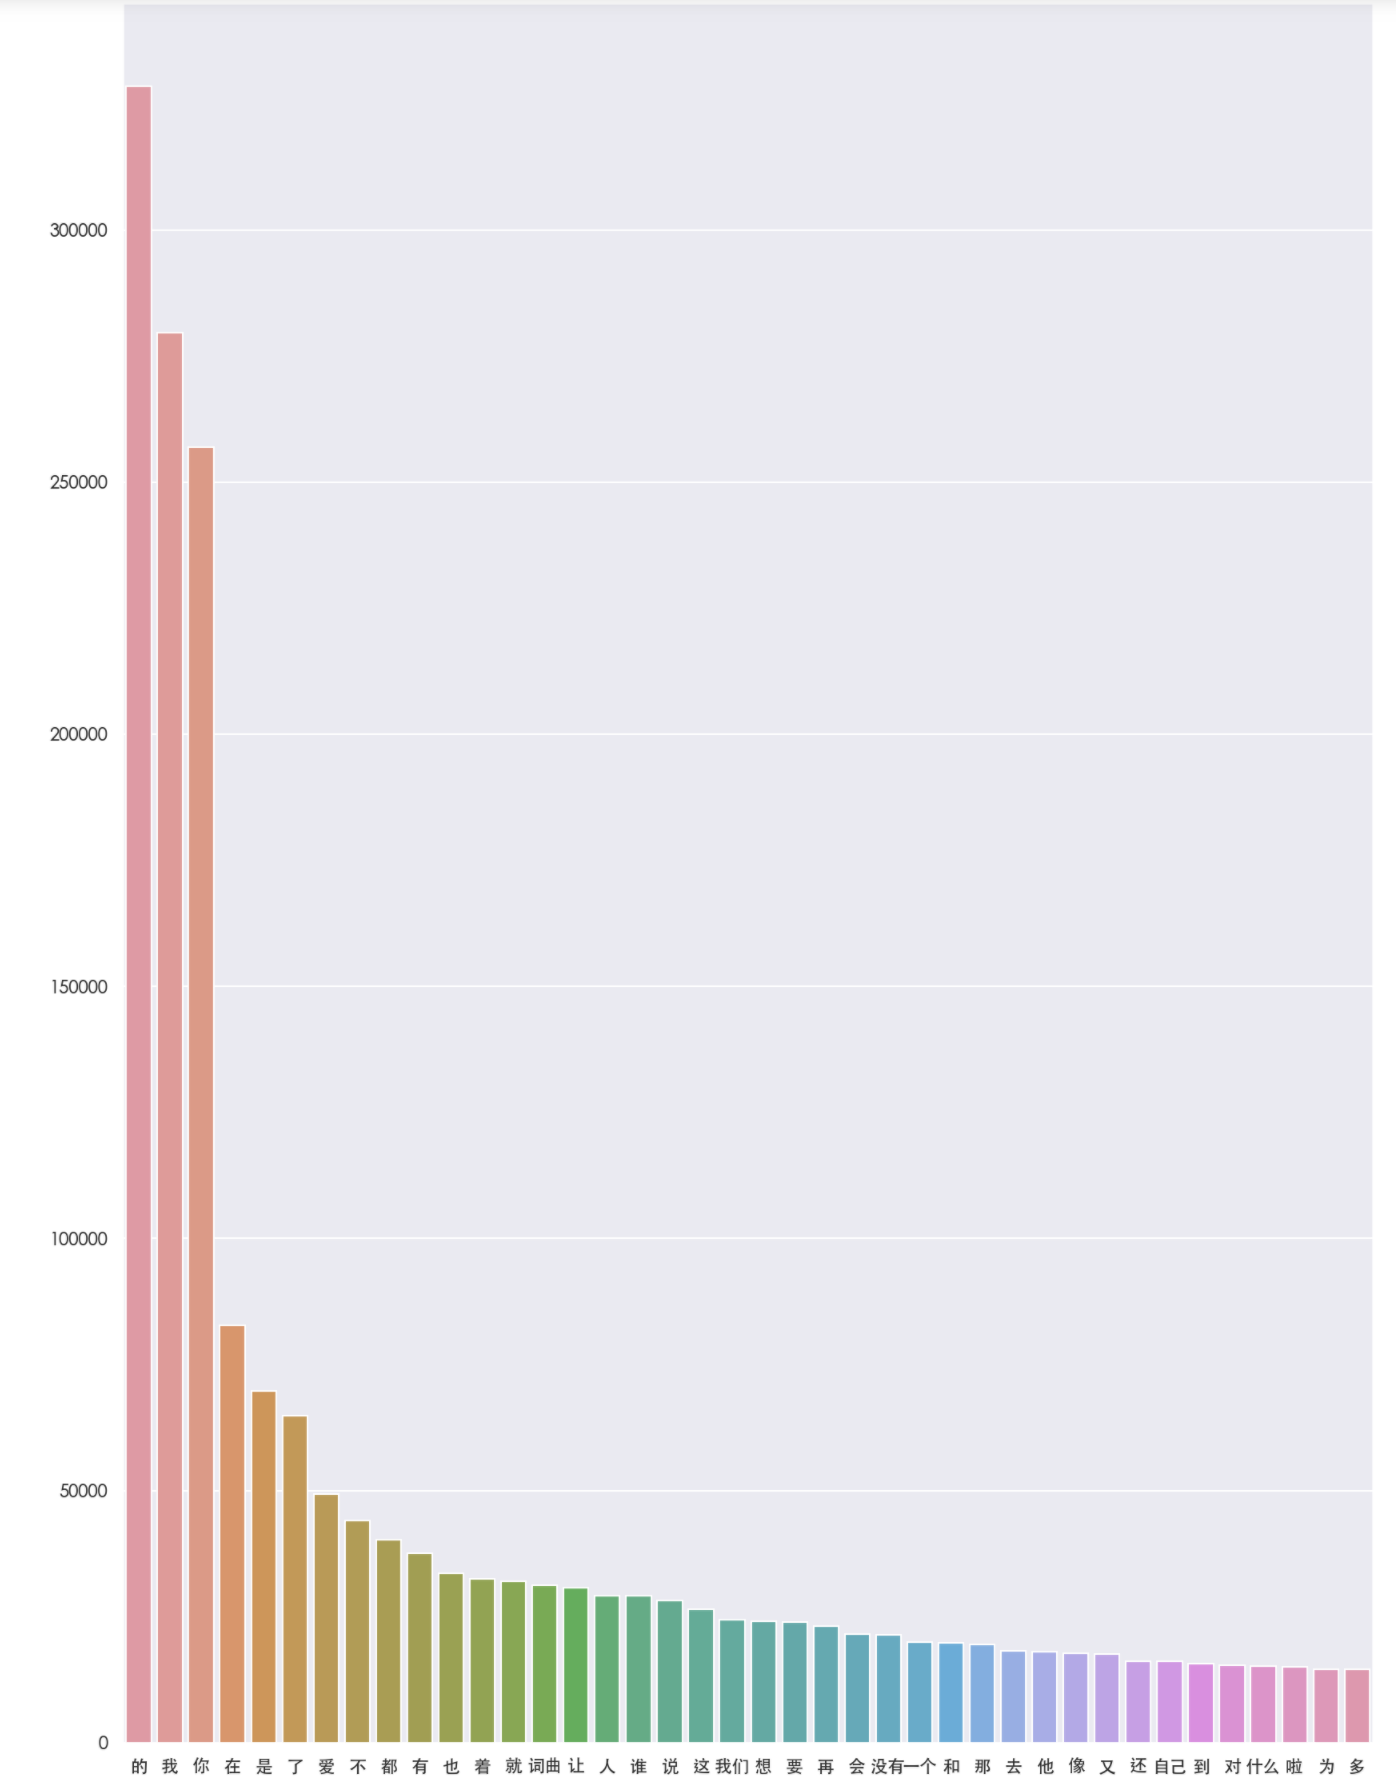

#### With stop words excluded:
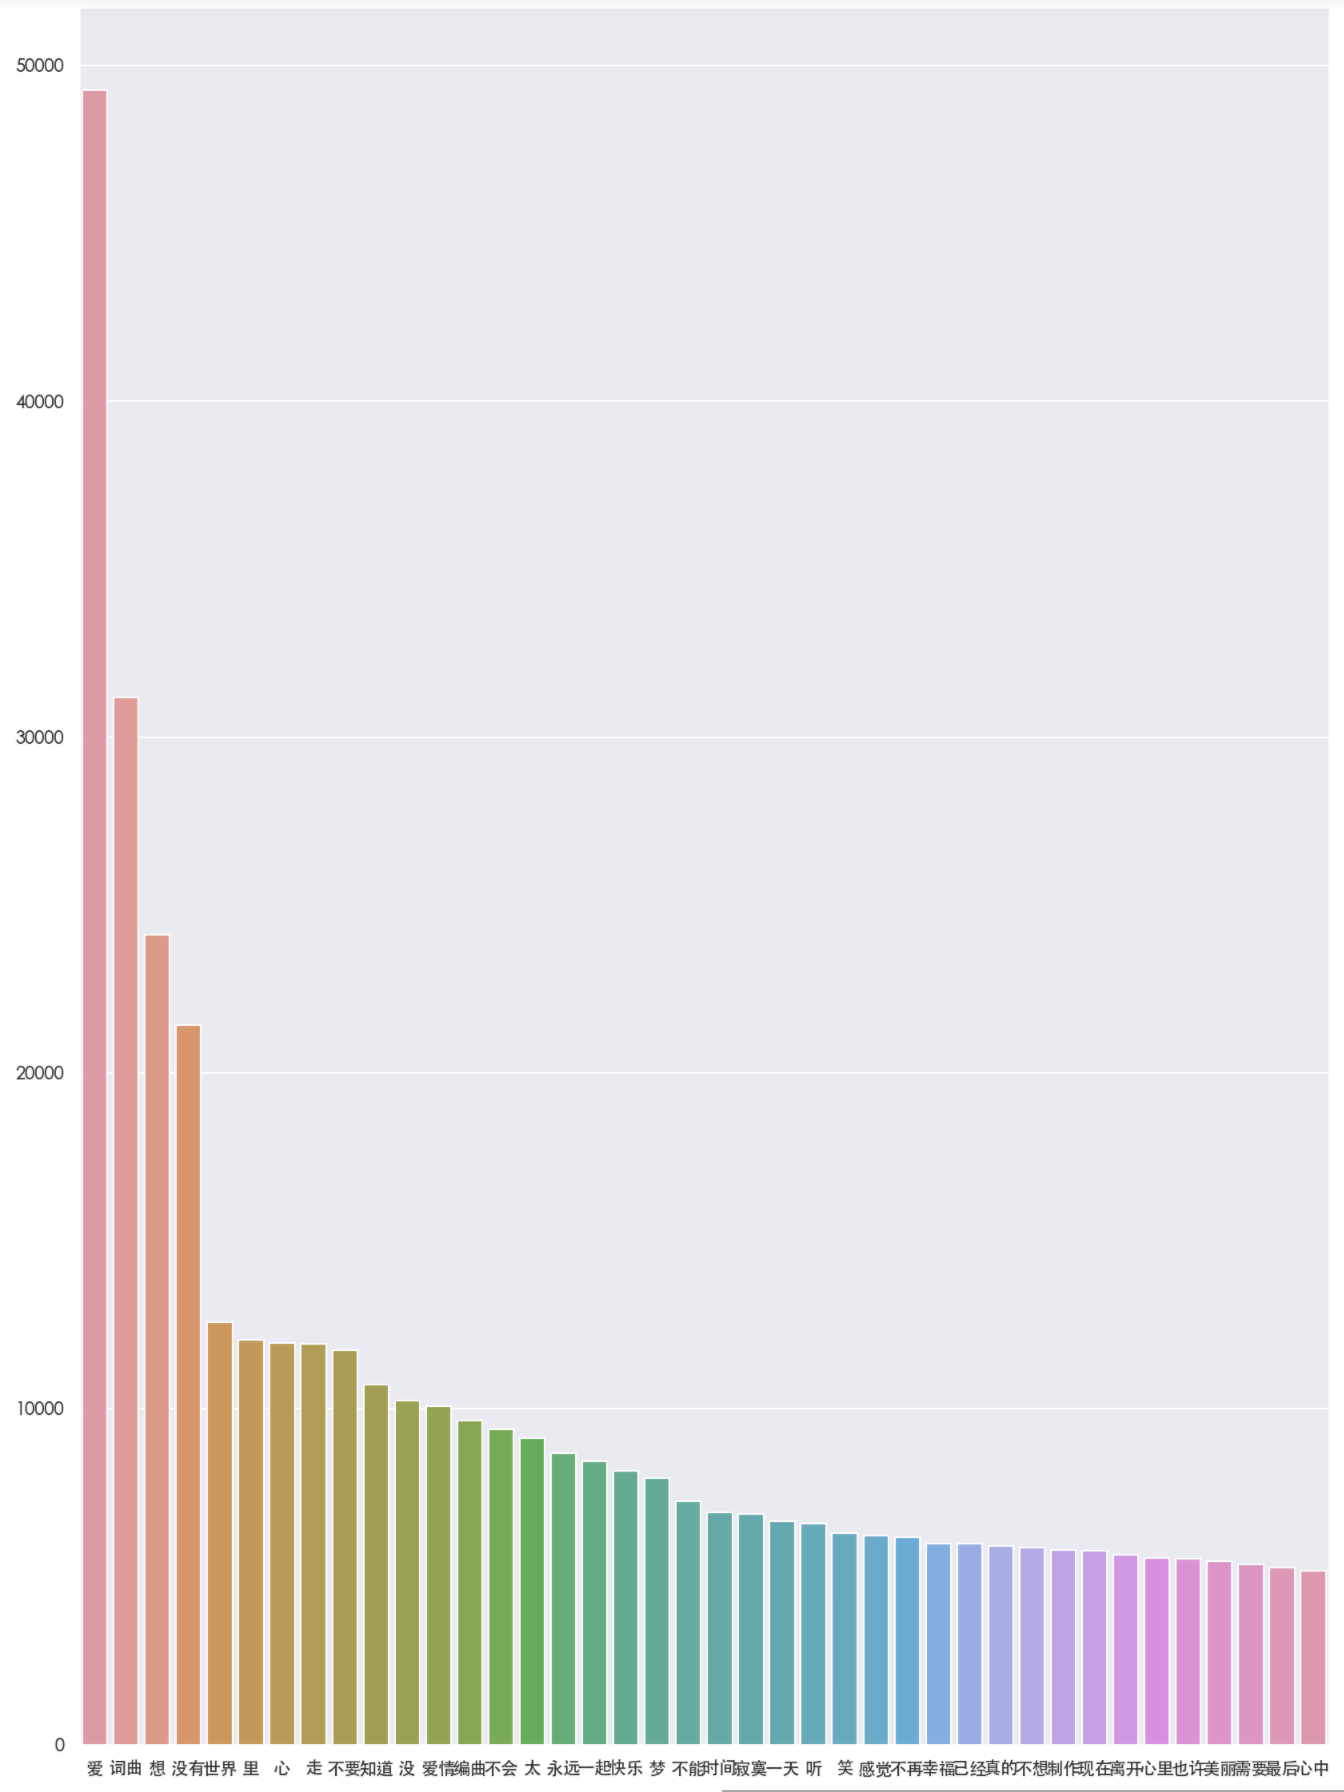

In [ ]:
# Import Jieba to tokenize lyrics
import jieba.posseg as pseg
import jieba

In [ ]:
# Tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

In [ ]:
lyrics = df_tracks_master_clean3_lyrics_genre_hsk_v2.lyrics

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=10000)
X_all = cvec.fit_transform(lyrics)

In [ ]:
X_all_df = pd.DataFrame(X_all.toarray(), columns =cvec.get_feature_names() )

In [ ]:
# pd.options.display.max_columns = None
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
pd.options.display.max_rows = None

sns.set(rc={'figure.figsize':(14,20)})
sns.set
# set Chinese as font for plot
plt.rcParams['font.family'] = ['Heiti TC']

plot_data = X_all_df.sum().sort_values(ascending=False)[0:40]
plot = sns.barplot(x = plot_data.index, y = plot_data);
plot.tick_params(axis='x', rotation=0)

#### 7.3.1. With Stop Words Removed

In [ ]:
stopwords(["zh"])

In [ ]:
cvec = CountVectorizer(tokenizer=man_token_jie,
                       max_features=10000,
                       stop_words=stopwords(["zh"]))

X_all = cvec.fit_transform(lyrics)
X_all_df = pd.DataFrame(X_all.toarray(), columns =cvec.get_feature_names() )
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
pd.options.display.max_rows = None

sns.set(rc={'figure.figsize':(14,20)})
sns.set
# set Chinese as font for plot
plt.rcParams['font.family'] = ['Heiti TC']

plot_data = X_all_df.sum().sort_values(ascending=False)[0:40]
plot = sns.barplot(x = plot_data.index, y = plot_data);
plot.tick_params(axis='x', rotation=0)

Inspect top 75 words. Not surprisingly love is the number one? I wonder if this is the same for english songs?

Some of these should be exluded: 
- 词曲 (word): included in lyrics in error during scraping.
- 编曲 (compose: as above
- 制作 (manufacture): as above (I think in this context it is referring to the record label
- 想: many meanings therefore will exclude
- 里: as above
- 心: heart and mind, emotive, keep

The rest look ok.

Some of the top words (roughly translated):
爱  love
没有 not having
不要 must not
爱情 romance
永远 foreve, eternal
一起 together, the same place
快乐 happiness
梦 dreams
不能 not able
时间 time

In [ ]:
X_all_df.sum().sort_values(ascending=False)[:75]

In [ ]:
# these look ok too
X_all_df.sum().sort_values(ascending=False)[75:150]

In [ ]:
updated_stopwords = list(stopwords(["zh"]))
updated_stopwords.extend(['词曲','编曲','制作','想','里'])
updated_stopwords = set(updated_stopwords)

In [ ]:
updated_stopwords

In [ ]:
# check this has worked: 
cvec = CountVectorizer(tokenizer=man_token_jie,
                       max_features=10000,
                       stop_words=updated_stopwords)

X_all = cvec.fit_transform(lyrics)
X_all_df = pd.DataFrame(X_all.toarray(), columns =cvec.get_feature_names() )
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
pd.options.display.max_rows = None

sns.set(rc={'figure.figsize':(14,20)})
sns.set
# set Chinese as font for plot
plt.rcParams['font.family'] = ['Heiti TC']

plot_data = X_all_df.sum().sort_values(ascending=False)[0:40]
plot = sns.barplot(x = plot_data.index, y = plot_data);
plot.tick_params(axis='x', rotation=0)

In [ ]:
X_all_df = pd.DataFrame(X_all.toarray(), columns =cvec.get_feature_names() )

X_all_df_filtered1 = pd.DataFrame(X_all_df.sum().sort_values(ascending=False)[:100])
additional_stops1 = X_all_df_filtered1.index

X_all_df_filtered2 = pd.DataFrame(X_all_df.sum().sort_values(ascending=False)[:300])
additional_stops2 = X_all_df_filtered2.index

In [ ]:
X_all_df_filtered.index

In [ ]:
# Also create stopword list that excludes top 100
updated_stopwords_2 = list(updated_stopwords)
updated_stopwords_2.extend(additional_stops1)
updated_stopwords_2 = set(updated_stopwords_2)
updated_stopwords_2

# Also create stopword list that excludes top 300
updated_stopwords_3 = list(updated_stopwords)
updated_stopwords_3.extend(additional_stops2)
updated_stopwords_3 = set(updated_stopwords_3)
updated_stopwords_3

In [ ]:
# check this has worked: 
cvec = CountVectorizer(tokenizer=man_token_jie,
                       max_features=10000,
                       stop_words=updated_stopwords_2)

X_all = cvec.fit_transform(lyrics)
X_all_df = pd.DataFrame(X_all.toarray(), columns =cvec.get_feature_names() )
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
pd.options.display.max_rows = None

sns.set(rc={'figure.figsize':(14,20)})
sns.set
# set Chinese as font for plot
plt.rcParams['font.family'] = ['Heiti TC']

plot_data = X_all_df.sum().sort_values(ascending=False)[0:40]
plot = sns.barplot(x = plot_data.index, y = plot_data);
plot.tick_params(axis='x', rotation=0)

## 8. Create English Song Data File

In [ ]:
english_tracks = grab_song_from_playlist(
    'spotify:playlist:5IgEf6pGG8q565BqhApd7x', 'english_tracks')

In [ ]:
# For each artist scrape similar artists and save the artist details in a new dataframe
df_eg_playlist_similar_artists = pd.DataFrame()
for ind, i in enumerate(english_tracks['artist_uri']):
    try:
        df_eg_playlist_similar_artists = df_eg_playlist_similar_artists.append(
            scrape_similar_artists(i))
    except:
        pass

df_similar_english_lang_artists = df_eg_playlist_similar_artists.drop_duplicates(
    subset='artist_id', keep="last")

In [ ]:
df_similar_english_lang_artists_expand = scrape_similar_artists_expansion(
    df_similar_english_lang_artists)

In [ ]:
# Loop through all of the artists scraped in 3.0 and get a list of albums
# Here we run through only the first 2 artists as an example
empty_list_albums = []

for artist_uri in tqdm(df_similar_english_lang_artists['artist_uri']):
    album_uri_temp = sp.artist_albums(artist_uri)
    for ind, i in enumerate(album_uri_temp['items']):
        empty_list_albums.append(album_uri_temp['items'][ind]['uri'])

In [ ]:
# loop through all the albums and get track ids for each (top 2 only here)
empty_list_tracks3 = []
for album in tqdm(empty_list_albums):
    temp = sp.album_tracks(album)['items']
    for ind, track in enumerate(temp):
        try:
            empty_list_tracks3.append(
                sp.album_tracks(album)['items'][ind]['uri'])
        except:
            pass

In [ ]:
# Loop through list of track IDs and get song information
tracks = []
for i in tqdm(empty_list_tracks3):
    try:
        track = getTrackFeatures(i)
        tracks.append(track)
    except:
        pass

In [ ]:
df_english_tracks_master = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_english_tracks_master.csv',
    sep=',',
    index_col=0)
df_english_tracks_master.shape

In [ ]:
artists = pd.DataFrame(
    df_english_tracks_master.artist.drop_duplicates().dropna())

In [ ]:
artists['genre'] = artists

In [ ]:
artists.head()

In [ ]:
def get_artist_genre(x):
    try:
        artist_uri = sp.search(
            x)['tracks']['items'][0]['album']['artists'][0]['uri']
        artist_genre = sp.artist(artist_uri)['genres'][0]
        return artist_genre
    except:
        return np.nan

In [ ]:
artists['genre'] = artists.genre.apply(get_artist_genre)

In [ ]:
df_english_tracks_master_genre = df_english_tracks_master.merge(artists,
                                                                on='artist',
                                                                how='inner')

In [ ]:
df_english_tracks_master_genre.to_csv('df_english_tracks_master_genre.csv')

## 9. Some Modelling

In [ ]:
# import data file
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

### 9.1. Logistic Regression to identify songs in Cantonese
#### Summary
Artis genre was available for ~85% of all songs. Of those with genre available roughly 23% are classified as "Cantopop". Taking random samples from this subset showed that many of the songs in this category are sung in Cantonese rather than Mandarin (although they are written with the same characters) and these may therefore 
need to be excluded. 

It would be helpful if I could identify songs that are "Cantopop" where genre is not available so these could also be excluded...

#### Question: Is it possible to train a model to identify  songs in the genre "Cantopop" using the subset of songs where genre is available and to then apply this model to the rest of the data where no genre is available?

The challenge with this approach is that "Cantopop" does not strictly mean the song is sang in Cantonese. In addition genre information is available on a artist basis rather than per song.


Model 5 proved to be the most effective model in classifying songs into the genre "Cantopop" with a final recall rate of 87%. Precision rates were disapointing (e.g. 60% for minority class in the test data) albeit not surprising. As I highlighted before there are fundamental limitations to this model given the genre "Cantopop" does not strictly mean that the song will be sung in Cantonese. I applied model 5 to the songs where no genre is available as shown below. However, I decided to not exclude Cantopop from the dataset given the unreliability of the model and that it would result in an unnecessarily large loss of in scope songs. 

#### 9.1.1. Preprocessing
Inspecting the data and creating X and Y variables. Classification will be between Cantopop (27%) and other genres. 

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2.value_counts(normalize=True)

Looking at the subset of songs where genre is available create a binary logistic regresssion to identify which songs are Cantonese. 

In [ ]:
# Create a new column which identifies if a song is Cantopop, other genre, or no genre available
df_c = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_c['is_canto'] = np.nan
df_c['is_canto'][(df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre2.notnull()) |
    (df_tracks_master_clean3_lyrics_genre_hsk_v2.Genre3.notnull())] = 0
df_c['is_canto'][(df_c.Genre2 == 'cantopop') |
                 (df_c.Genre3 == 'classic cantopop')] = 1

In [ ]:
display(df_c['is_canto'].value_counts(dropna=False))
display(df_c['is_canto'].value_counts(normalize=True, dropna=False))

In [ ]:
# Crate a new data
df_c_clean = df_c[df_c.is_canto.notnull()]

In [ ]:
display(df_c_clean['is_canto'].value_counts(dropna=False))
display(df_c_clean['is_canto'].value_counts(normalize=True, dropna=False))

Approximately 27% of the songs are classified as Cantopop

In [ ]:
y = df_c_clean['is_canto']
X = df_c_clean['lyrics']

In [ ]:
X.shape[0], y.shape[0]

#### 9.1.2. Function for plots
A function to show ROC, confusion matrix etc. for models.

In [ ]:
# Function to return some plots for Logistic Regression
def logist_plots(lr, X_train, y_train, X_test, y_test):

    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
    from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
    from matplotlib.colors import ListedColormap
    import scikitplot as skplt

    # classification report
    predictions_train = lr.predict(X_train)
    predictions_test = lr.predict(X_test)
    print('y_train classification report:')
    print(classification_report(y_train, predictions_train))
    print('y_test classification report:')
    print(classification_report(y_test, predictions_test))

    # plot the confusion matrix
    fig, ax = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)
    plot_confusion_matrix(lr,
                          X_train,
                          y_train,
                          cmap='Blues',
                          ax=ax[0],xticks_rotation='vertical' )
    plot_confusion_matrix(lr,
                          X_test,
                          y_test,
                          cmap='Blues',
                          ax=ax[1],xticks_rotation='vertical')
    
    for a in ax:
        texts = a.texts
        for text in texts:
            text.set_size(20)
    plt.show()

    # ROC  curves:
    print('ROC Curves:')
    fig_rec, ax_rec = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
    cmap = ListedColormap(sns.color_palette("husl", len(lr.classes_)))
    probabilities_train = lr.predict_proba(X_train)
    probabilities_test = lr.predict_proba(X_test)
    skplt.metrics.plot_roc(y_train,
                           probabilities_train,
                           cmap=cmap,
                           ax=ax_rec[0])
    skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap, ax=ax_rec[1])
    ax_rec[0].set_title('Train')
    ax_rec[1].set_title('Test')
    plt.show()

    # Precision Recall:
    print('Precision Recall Curve:')
    fig_prec, ax_prec = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
    cmap = ListedColormap(sns.color_palette("husl", len(lr.classes_)))
    probabilities_train = lr.predict_proba(X_train)
    probabilities_test = lr.predict_proba(X_test)
    skplt.metrics.plot_precision_recall(y_train,
                                        probabilities_train,
                                        cmap=cmap,
                                        ax=ax_prec[0])
    skplt.metrics.plot_precision_recall(y_test,
                                        probabilities_test,
                                        cmap=cmap,
                                        ax=ax_prec[1])
    ax_prec[0].set_title('Train')
    ax_prec[1].set_title('Test')
    plt.show()

#     # Plot False Positive Rate and Accuracy Change Threshold
#     #  false positive rate as threshold changed:
#     print('Threholds (test data) impact on Accuracy / False Positive Rate:')
#     false_positives = []
#     for thresh in np.arange(1, 100) / 100.:
#         labeled_1 = np.array(
#             [1 if x >= thresh else 0 for x in lr.predict_proba(X_test)[:, 1]])
#         fp = np.mean((y_test == 0) & (labeled_1 == 1))
#         false_positives.append((thresh, fp))
#     #     print('Threshold:', thresh, 'false positives:', fp)
#     false_positives = np.array(false_positives)

#     #  accuracy change with threshold
#     accuracies = []
#     for thresh in np.arange(1, 100) / 100.:
#         labeled_1 = np.array(
#             [1 if x >= thresh else 0 for x in lr.predict_proba(X_test)[:, 1]])
#         acc = np.mean(y_test == labeled_1)
#         accuracies.append((thresh, acc))
#     #     print('Threshold:', thresh, 'Correct predictions:', acc)
#     accuracies = np.array(accuracies)

#     fig_acc, ax_acc = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
#     ax_acc[0].plot(false_positives[:, 0], false_positives[:, 1], lw=2)
#     ax_acc[0].set_xlabel('threshold')
#     ax_acc[0].set_ylabel('false positive fraction')

#     ax_acc[1].plot(*accuracies.T, lw=2)
#     ax_acc[1].set_xlabel('threshold')
#     ax_acc[1].set_ylabel('accuracy')
#     plt.show()

#### 9.1.3. Tokenizing Lyrics
I initially ran the logistic regression model using SnowNLP (as used in previous EDA stages) to tokenize the lyrics. However, the model performed poorly and was slow to run. I switched to an alernative tokenizer "Jieba", which increased computation time and improved results and I have used this in the models below. 

In [ ]:
# Import Jieba to tokenize lyrics
import jieba.posseg as pseg
import jieba

In [ ]:
# Turn off warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Demonstration of Jieba, note it recognises that 朋 and 友 together form the word 朋友 -> friend
sentence = '你是我的好朋友'
jieba.lcut(sentence)

In [ ]:
# Create a customer tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

#### 9.1.4. Logistic Regression Model (1)
The mean cross validated score suggests that we can expect to make correct classifications in 85% of cases which compares with the base line of 72% if we were to apply the majority class. From the classification report it can be seen that the model tends to favour the majority class which resulted in a training recall score of 65% for the minority class which in turn impacted the precision scores of both classes.

Could the recall of the minority class (Cantopop) be improved by assigning weights?


In [ ]:
# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=1000)
cvec.fit(X_train)
cvec.get_feature_names()[:5]

In [ ]:
# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

In [ ]:
# Import and fit a logistic regression model and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(lr.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(lr.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

Scores reflects the mean accuracy on the given test data and labels:
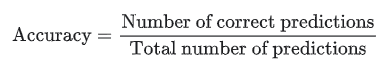

The mean cross validated score suggests that we can expect to make correct classifications in 85% of cases which compares with the base line of 72% if we were to apply the majority class. From the classification report it can be seen that the model tends to favour the majority class which resulted in a training recall score of 65% for the minority class which in turn impacted the precision scores of both classes.

Could the recall of the minority class (is Cantonese) be improved by assigning weights?

In [ ]:
logist_plots(lr,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.1.5. Logistic Regression Model (2):  weights assigned to each class
Assigning a weight of 2 to the minority class improved the test recall rate from 63% previously to 81%. This was at the expense of majority class recall which declined from 94% to 76%. The mean cross validation score was 77% only slighlty ahead of the base line. 

In [ ]:
# Import and fit a logistic regression model and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

# assign weights to the classes
w = {0: 1, 1: 4}
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight=w)
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(lr.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(lr.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.1.6. Logistic Regression Model (3):  increasing the number of features to include
I increased the number of max_features from 1000 to 5000. This increased the computation time but resulted in improved scores. The comparatively stronger training score of 90% compared with the mean cross val score of 78% suggests the model could be overfit. The recall of the minority class of 75% in the test data remains low. This could be improved by further increasing the weight applied to the minority class.


In [ ]:
# Get Tran test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.4,
                                                    random_state=1)

cvec = CountVectorizer(tokenizer=man_token_jie, max_features=5000)
cvec.fit(X_train)
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

# Import and fit a logistic regression model and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
w = {0: 1, 1: 4}
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight=w)
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(lr.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(lr.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr=lr,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.1.7. Logistic Regression Model (4):  with cross validation
I experimented with using Logistic Regression with cross validation to improve regularization. I used StratifiedKFold so that the split of classes was kept balanced during cross validation. To reduce computation time I tried only three alpha values and three L1 ratios and set the max_iterations to 100. Finally I cranked up the weight on the minority class to six (previously set at four) to try and further increase recall of the minority class.

Given that I increased the weighting on the minority class the training score is not directly comparable with the previous model and based on this metric alone would make this model look inferior. However, this is due to the lower  precision for the majority class which came at the expense of improving recall for the minority class which increased to 84% in the test data from 73% previously. The training, test and mean cross validation scores are more closely alligned (75-87%) suggesting that the model is less overfit. Overall this model is an improvement on previous ones however the model performance remains poor. 

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score

Bold = '\033[1m'
Normal = '\033[0m'

# Get Tran test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.4,random_state=1)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

cvec = CountVectorizer(tokenizer=man_token_jie, max_features=5000)
cvec.fit(X_train)
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

# Cs represent lambda, therefore penalty severity
# 10 ^-4 as alpha, then 15 intervals up to 4^10
# for multi class add --> multi_class='ovr'    and change solver to --->     'solver': ['liblinear']
w = {0: 1, 1: 6}
LRCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 3),
                            penalty='elasticnet',
                            max_iter=100,
                            cv=skf,
                            solver='saga',
                            l1_ratios=[0.001, 0.1, 0.5],
                            n_jobs=6,
                            class_weight=w)  # cv=LRCV_kfolds
# fit the model
LRCV.fit(X_train, y_train)

lr_scores = cross_val_score(LRCV, X_train, y_train, cv=skf, n_jobs=6)

# get the best alpha
print(Bold + 'LRCV Model:' + Normal)
print('LRCV Best alpha:', LRCV.C_)
# get the best l1-ratio
print('Best l1-ratio:', LRCV.l1_ratio_)
# evaluate on the training set
print('LRCV CV Training score:', LRCV.score(X_train, y_train))
# evaluate on the test set
print("LRCV Test Score:", LRCV.score(X_test, y_test), '\n')
# ROC Train and test score
print('ROC Train and Test Score:',
      roc_auc_score(y_train,
                    LRCV.predict_proba(X_train)[:, 1]),
      roc_auc_score(y_test,
                    LRCV.predict_proba(X_test)[:, 1]))

print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr=LRCV,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.1.8. Logistic Regression Model (5):  with cross validation and stop words

Finally I tried adding stop words to remove the most commonly used words. My hypothesis was that this would reduce the effiacy of the model, as I suspected that it would be the most commonly used words which best distinguish a dialect. This proved to be the case with the minority class test recall declining to 81% (previously 87%). 

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score

Bold = '\033[1m'
Normal = '\033[0m'

# Get Tran test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.4,
                                                    random_state=1)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

cvec = CountVectorizer(tokenizer=man_token_jie,
                       max_features=5000,
                       stop_words=stopwords(["zh"]))
cvec.fit(X_train)
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

# Cs represent lambda, therefore penalty severity
# 10 ^-4 as alpha, then 15 intervals up to 4^10
# for multi class add --> multi_class='ovr'    and change solver to --->     'solver': ['liblinear']

w = {0: 1, 1: 6}
LRCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 3),
                            penalty='elasticnet',
                            max_iter=100,
                            cv=skf,
                            solver='saga',
                            l1_ratios=[0.001, 0.1, 0.5],
                            n_jobs=6,
                            class_weight=w)  # cv=LRCV_kfolds
# fit the model
LRCV.fit(X_train, y_train)

lr_scores = cross_val_score(LRCV, X_train, y_train, cv=skf, n_jobs=6)

### Some outputs

# get the best alpha
print(Bold + 'LRCV Model:' + Normal)
print('LRCV Best alpha:', LRCV.C_)
# get the best l1-ratio
print('Best l1-ratio:', LRCV.l1_ratio_)
# evaluate on the training set
print('LRCV CV Training score:', LRCV.score(X_train, y_train))
# evaluate on the test set
print("LRCV Test Score:", LRCV.score(X_test, y_test), '\n')
# ROC Train and test score
print('ROC Train and Test Score:',
      roc_auc_score(y_train,
                    LRCV.predict_proba(X_train)[:, 1]),
      roc_auc_score(y_test,
                    LRCV.predict_proba(X_test)[:, 1]))

print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr=LRCV,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.2.0 Appying Model to Data with no Genre

In [ ]:
# Apply model 5 to the songs where no genre is available to label those that are suspected of being "Cantopop"
df_tracks_no_genre = df_tracks_master_clean2_lyrics_genre_hsk_v2[
    (df_tracks_master_clean2_lyrics_genre_hsk_v2.genre_2.isnull()) |
    (df_tracks_master_clean2_lyrics_genre_hsk_v2.genre_2.isnull())]
df_tracks_no_genre_lyrics = df_tracks_no_genre['lyrics']

In [ ]:
cvec_mat_no_genre = cvec.transform(df_tracks_no_genre_lyrics)

In [ ]:
df_tracks_no_genre['predict_is_canton'] = LRCV.predict(cvec_mat_no_genre)

In [ ]:
df_tracks_no_genre.predict_is_canton.value_counts()

### 9.2. Spotify Meta Data to HSK Relationship
#### Summary 
Finding songs that are accessible at the right level is computationally intensive and time consuming given that the method used so far requires scraping lyrics for each song in the database and then processing these. Is it possible to speed up this process by identifying songs that are more likely to be at the right level based on Spotify data?

In model 1 I tried to identify songs that are HSK 1-4 vs HSK 5-6 from Spotify song meta data. The mean cross validation score was 54% compared with the base line of 47%. This score suggests that there is very limited information contained in song meta data for grading HSK level. 

In model 2 I added artist and genre. The mean cross validation score improved to 60%. The coefficient with the greatest weight was Chinese R&B. When looking at this genre it can be seen that 86% of songs have lyrics within HSK1-4 vs. the base line of 52%. Singoaporean Mandopop was the second coefficient and has 68% in scope for HSK 1-4. 

Whilst the model was poor overall at identifying HSK level it was able to identify some genres which may be more accessible to language learners. 

#### 9.2.1. Modelling

In [ ]:
df_h4 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h4['is_h4'] = 0
df_h4['is_h4'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk4 > 0.77] = 1

In [ ]:
df_h4['is_h4'].value_counts()

In [ ]:
X = df_h4[[
    'song_duration_ms', 'is_explicit', 'length', 'popularity', 'acousticness',
    'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'tempo', 'time_signature', 'is_h4'
]]

y = X.pop('is_h4')

In [ ]:
# Get Tran test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

# Import and fit a logistic regression model and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

Bold = '\033[1m'
Normal = '\033[0m'

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
w = {0: 1, 1: 1}
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight=w)
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(lr.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(lr.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr=lr,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.2.2. Spotify Meta Data Plus Genre

In [ ]:
X = df_h4[[
    'artist', 'Genre1', 'Genre2', 'Genre3', 'song_duration_ms',
    'is_explicit', 'length', 'popularity', 'acousticness', 'danceability',
    'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'time_signature', 'is_h4']]
X = pd.get_dummies(X,columns=['artist', 'Genre1', 'Genre2', 'Genre3'],drop_first=True)
y = X.pop('is_h4')

There is some improvement in the scores overall by adding artist and genre. The mean cross validation score of 60% was ahead of the baseline score of 47%. 

In [ ]:
# Get Tran test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

# Import and fit a logistic regression model and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

Bold = '\033[1m'
Normal = '\033[0m'

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
w = {0: 1, 1: 1}
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight=w)
lr.fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(lr.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(lr.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')
logist_plots(lr=lr,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [ ]:
results = pd.DataFrame(list(zip(
    X_train.columns,
    lr.coef_[0],
)),
                       columns=['coef',
                                'coef_mag']).sort_values(by='coef_mag',
                                                         ascending=False)

In [ ]:
results.head(15)

Does this mean that Chinese R&B is the most accessible genre for Chinese language learners??

In [ ]:
df_h4['is_h4'].value_counts(normalize=True)

In [ ]:
df_h4['is_h4'][df_h4['Genre2'] == 'chinese r&b'].value_counts(normalize=True)

Yes! Chinese R&B songs fall into category HSK 1 to HSK 4 in 86% of cases vs. the overall genre average of 52%. 

In [ ]:
df_h4['is_h4'][df_h4['Genre2'] == 'singaporean mandopop'].value_counts(normalize=True)

Similarly for Singaporean Mandopop

### 9.3 Binary Classification of HSK Based on Lyrics

#### 9.3.1. Binary Classification is HSK 1 - 5: Logistic Regression, TfidfVectorizer,  weights (50:50)
- Mean Cross validation score of 61% vs. base line of 53%. 
- Recall (train) of HSK5 is 100% with precision of 82%. 
- Recall (train) of 75% for not HSK5 with precision of 100%.

In [ ]:
# import data file
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'

X = df_h5[['lyrics','is_h5'
]]

y = X.pop('is_h5')
X=X['lyrics']

df_h5['is_h5'].value_counts()

In [ ]:
# Logistis Regression
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics


# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {'HSK5': 1, 'NotHSK': 1}

model = make_pipeline(TfidfVectorizer(stop_words=updated_stopwords,
                                      # sublinear_tf=True,
                                      max_df=2,
                                      min_df = 1,
                                      max_features=50000,
                                      tokenizer=man_token_jie,
                                      norm='l2'),
                                      LogisticRegression(solver='lbfgs', 
                                        multi_class='ovr', 
                                        class_weight=w),
                      )

model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

In [ ]:
logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.2.Binary Classification is HSK 1 - 5: Logistic Regression, TfidfVectorizer,  weights (1.05 on minority)

There is a tipping point for weights above and below 1.2:

Applying weights of 1.1-1.19:
- Mean cross validation score reduced to 53% vs. base line of 53% and 63% previously. 
- Recall (train) of HSK5 98% precision of 83%.
- Recall (train) of NotHSK5 78% and precision of 98%

Applying weights of 1.2:
- Mean cross validation score reduced to 53%
- Recall (train) of HSK5 61% precision of 100%.
- Recall (train) of NotHSK5 100% and precision of 70%

In [ ]:
## wieght updated to w = {'HSK5': 1, 'NotHSK': 1.199}
w = {'HSK5': 1, 'NotHSK': 1.199}

model = make_pipeline(TfidfVectorizer(stop_words=updated_stopwords,
                                      # sublinear_tf=True,
                                      max_df=2,
                                      min_df = 1,
                                      max_features=50000,
                                      tokenizer=man_token_jie,
                                      norm='l2'),
                                      LogisticRegression(solver='lbfgs', 
                                        multi_class='ovr', 
                                        class_weight=w),
                      )

model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

In [ ]:
logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [ ]:
# weights updated to w = {'HSK5': 1, 'NotHSK': 1.2}
w = {'HSK5': 1, 'NotHSK': 1.2}

model = make_pipeline(TfidfVectorizer(stop_words=updated_stopwords,
                                      # sublinear_tf=True,
                                      max_df=2,
                                      min_df = 1,
                                      max_features=50000,
                                      tokenizer=man_token_jie,
                                      norm='l2'),
                                      LogisticRegression(solver='lbfgs', 
                                        multi_class='ovr', 
                                        class_weight=w),
                      )

model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.2.Binary Classification is HSK 1 - 5: Logistic Regression, CountVectorizer,  weights (1.2 on minority)
Given that HSK levels are losely based on frequency of word occurence it makes sense to try and CountVectorizer model.

Weights were kept even at 1:1.

- Training score of 99.7% (vs. baseline of 53%).
- Mean cross validation score of 77% (ahead of previous best of 63%).
- Recall (train) score of HSK5 100% precision of 100%
- Recall (train) score of NotHSK5 100% precision of 100%
- Recall and Precision of Test data 76-80% accross both classes

Model has significantly improved using CVEC. Strong training score vs. mean cross validation score implies some model overfitting. 

In [ ]:
# weights kept at 1:1
w = {'HSK5': 1, 'NotHSK': 1}

model = make_pipeline(CountVectorizer(stop_words=updated_stopwords,
                                      # sublinear_tf=True,
                                      max_features=50000,
                                      tokenizer=man_token_jie),
                                      LogisticRegression(solver='lbfgs', 
                                        multi_class='ovr', 
                                        class_weight=w),
                      )

model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.3. Binary Regression: All Classifiers

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)


In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics




w = {'HSK5': 1, 'NotHSK': 1}

cvec = CountVectorizer(stop_words=updated_stopwords,
                                      # sublinear_tf=True,
                                      max_features=50000,
                                      tokenizer=man_token_jie)




cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)


feature_names = np.array(cvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))
        
        try: 
            if feature_names is not None:
                print("top 10 keywords per class:")
                for i, category in enumerate(set(y_train.values)):
                    top10 = np.argsort(clf.coef_[i])[-10:]
                    print((trim("%s: %s"
                                % (category, " ".join(feature_names[top10])))))
            print()
        except: print('Top 10 features not available')
            
    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=set(y_train.values))))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in ((Perceptron(max_iter=1000, tol=1e-3, class_weight=w, n_jobs=-1), "Perceptron"),(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight=w,n_jobs=-1), "Passive-Aggressive"),(KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),(RandomForestClassifier(n_estimators=100, class_weight=w, n_jobs=-1), "Random forest")):
    print(('=' * 80))
    print(name)
    try: 
        results.append(benchmark(clf))
    except:
        results.append(np.nan)

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    try: 
        results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                                dual=False)))
    except:  results.append(np.nan)

    # Train SGD model
    try: 
        results.append(benchmark(SGDClassifier(alpha=.0001,
                                               penalty=penalty,
                                               max_iter=1000,
                                               tol=1e-3)))
    except: results.append(np.nan)

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
try: 
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty="elasticnet",
                                           max_iter=1000,
                                           tol=1e-3)))
except: results.append(np.nan)
    
# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
try:
    results.append(benchmark(NearestCentroid()))
except:
    retults.append(np.nan)
# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
try: 
    results.append(benchmark(MultinomialNB(alpha=.01)))
    results.append(benchmark(BernoulliNB(alpha=.01)))
except:
        results.append(np.nan)
        results.append(np.nan)

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
try:
    results.append(benchmark(Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
        ('classification', LinearSVC(penalty="l2"))])))
except:
    results.append(np.nan)
    results.append(np.nan
                  )
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

#### 9.3.4. Neural Network modes: Multilayer Perceptron Feed-Forward network - Setup Run

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=50000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

model = MLPClassifier(solver='lbfgs',
                    alpha=10**(-10),
                    hidden_layer_sizes=1,
                    activation='identity',
                    random_state=1,
                    batch_size='auto')


model.fit(X_train, y_train)



Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.5. Neural Network modes: Multilayer Perceptron Feed-Forward network
Params:
- max_feat: 1000
- activation: 'relu', 
- hidden_layer: (20)
- max iterations: default (200)

Results:
- run time:(2mins)
- MSE: 69%

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=1000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

model = MLPClassifier(solver='adam',
                    alpha=10**(0),
                    hidden_layer_sizes=(20),
                    activation='relu',
                    random_state=1,
                    batch_size='auto',
                    warm_start=True, max_iter=200, verbose=True)


model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.6. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', (500, 10)

Params:
- max_feat: 2000
- activation: 'relu', 
- hidden_layer: (100,100)
- max iterations: default (200)

Results:
- run time:(10mins)
- MSE: 72%

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=2000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

model = MLPClassifier(solver='adam',
                    alpha=10**(1),
                    hidden_layer_sizes=(100, 100),
                    activation='relu',
                    random_state=1,
                    batch_size='auto',verbose=True, warm_start=True)


model.fit(X_train, y_train)

Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.6. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search
Params:
- max_feat: 5000
- activation: 'relu', 
- hidden_layer: [(20, 20, 20, 20, 20), (10,120,10)]
- alpha: [10^(0), 10^(0.1)],
- max iterations: default (400)

Results:
- run time: 4 mins
- MSE: 72%

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=5000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

In [ ]:
params = {'solver':['adam'],
                'alpha':[10**(0), 10**(0.1)],
                'hidden_layer_sizes':[(20, 20, 20, 20, 20), (10,120,10)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[400], 'verbose':[True]}


skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

#### 9.3.6. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search
- max_feat: 5000
- activation: 'relu', 
- hidden_layer: [(20, 20, 20, 20), (40,40,40,40)]
- alpha: [10^(1), 10^(2)],
- max iterations: default (400)

Results:
- run time: 4 mins
- MSE: 74.8%

In [ ]:
params = {'solver':['adam'],
                'alpha':[10, 10**(1),10**(2)],
                'hidden_layer_sizes':[(20, 20, 20, 20), (40,40,40,40)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[400], 'verbose':[True],'warm_start':[False]}


skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

#### 9.3.7. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search
- max_feat: 5000
- activation: 'relu', 
- hidden_layer: [(20, 20, 20, 20,20), (25,25,25,25,25),(20,20,20)]
- alpha: [2, 10,15],
- max iterations: default (400)

Results:
- run time: 5 mins
- MSE: 74.1%

In [ ]:
params = {'solver':['adam'],
                'alpha':[2, 10,15],
                'hidden_layer_sizes':[(20, 20, 20, 20,20), (20,20,20)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[500], 'verbose':[True],'warm_start':[True]}


skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_

In [ ]:
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

#### 9.3.8. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search
- increased tvec features to 10k
- max_feat: 50k
- activation: 'relu', 
- hidden_layer: [(20,20,20)]
- alpha: [10],
- max iterations: default (400)

Results:
- run time: 
- MSE: 77%

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie, max_features=50000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

In [ ]:
params = {'solver':['adam'],
                'alpha':[10],
                'hidden_layer_sizes':[(20,20,20)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[500], 'verbose':[True],'warm_start':[True]}


skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_

In [ ]:
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

#### 9.3.9. Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search SNOW NLP
- increased tvec features to 10k
- max_feat: 50k
- activation: 'relu', 
- hidden_layer: [(20,20,20)]
- alpha: [10],
- max iterations: default (400)

Results:
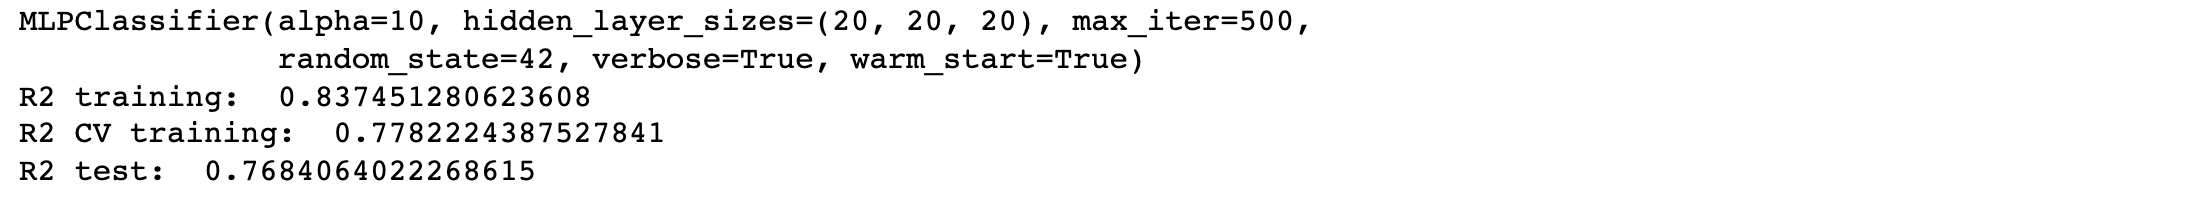
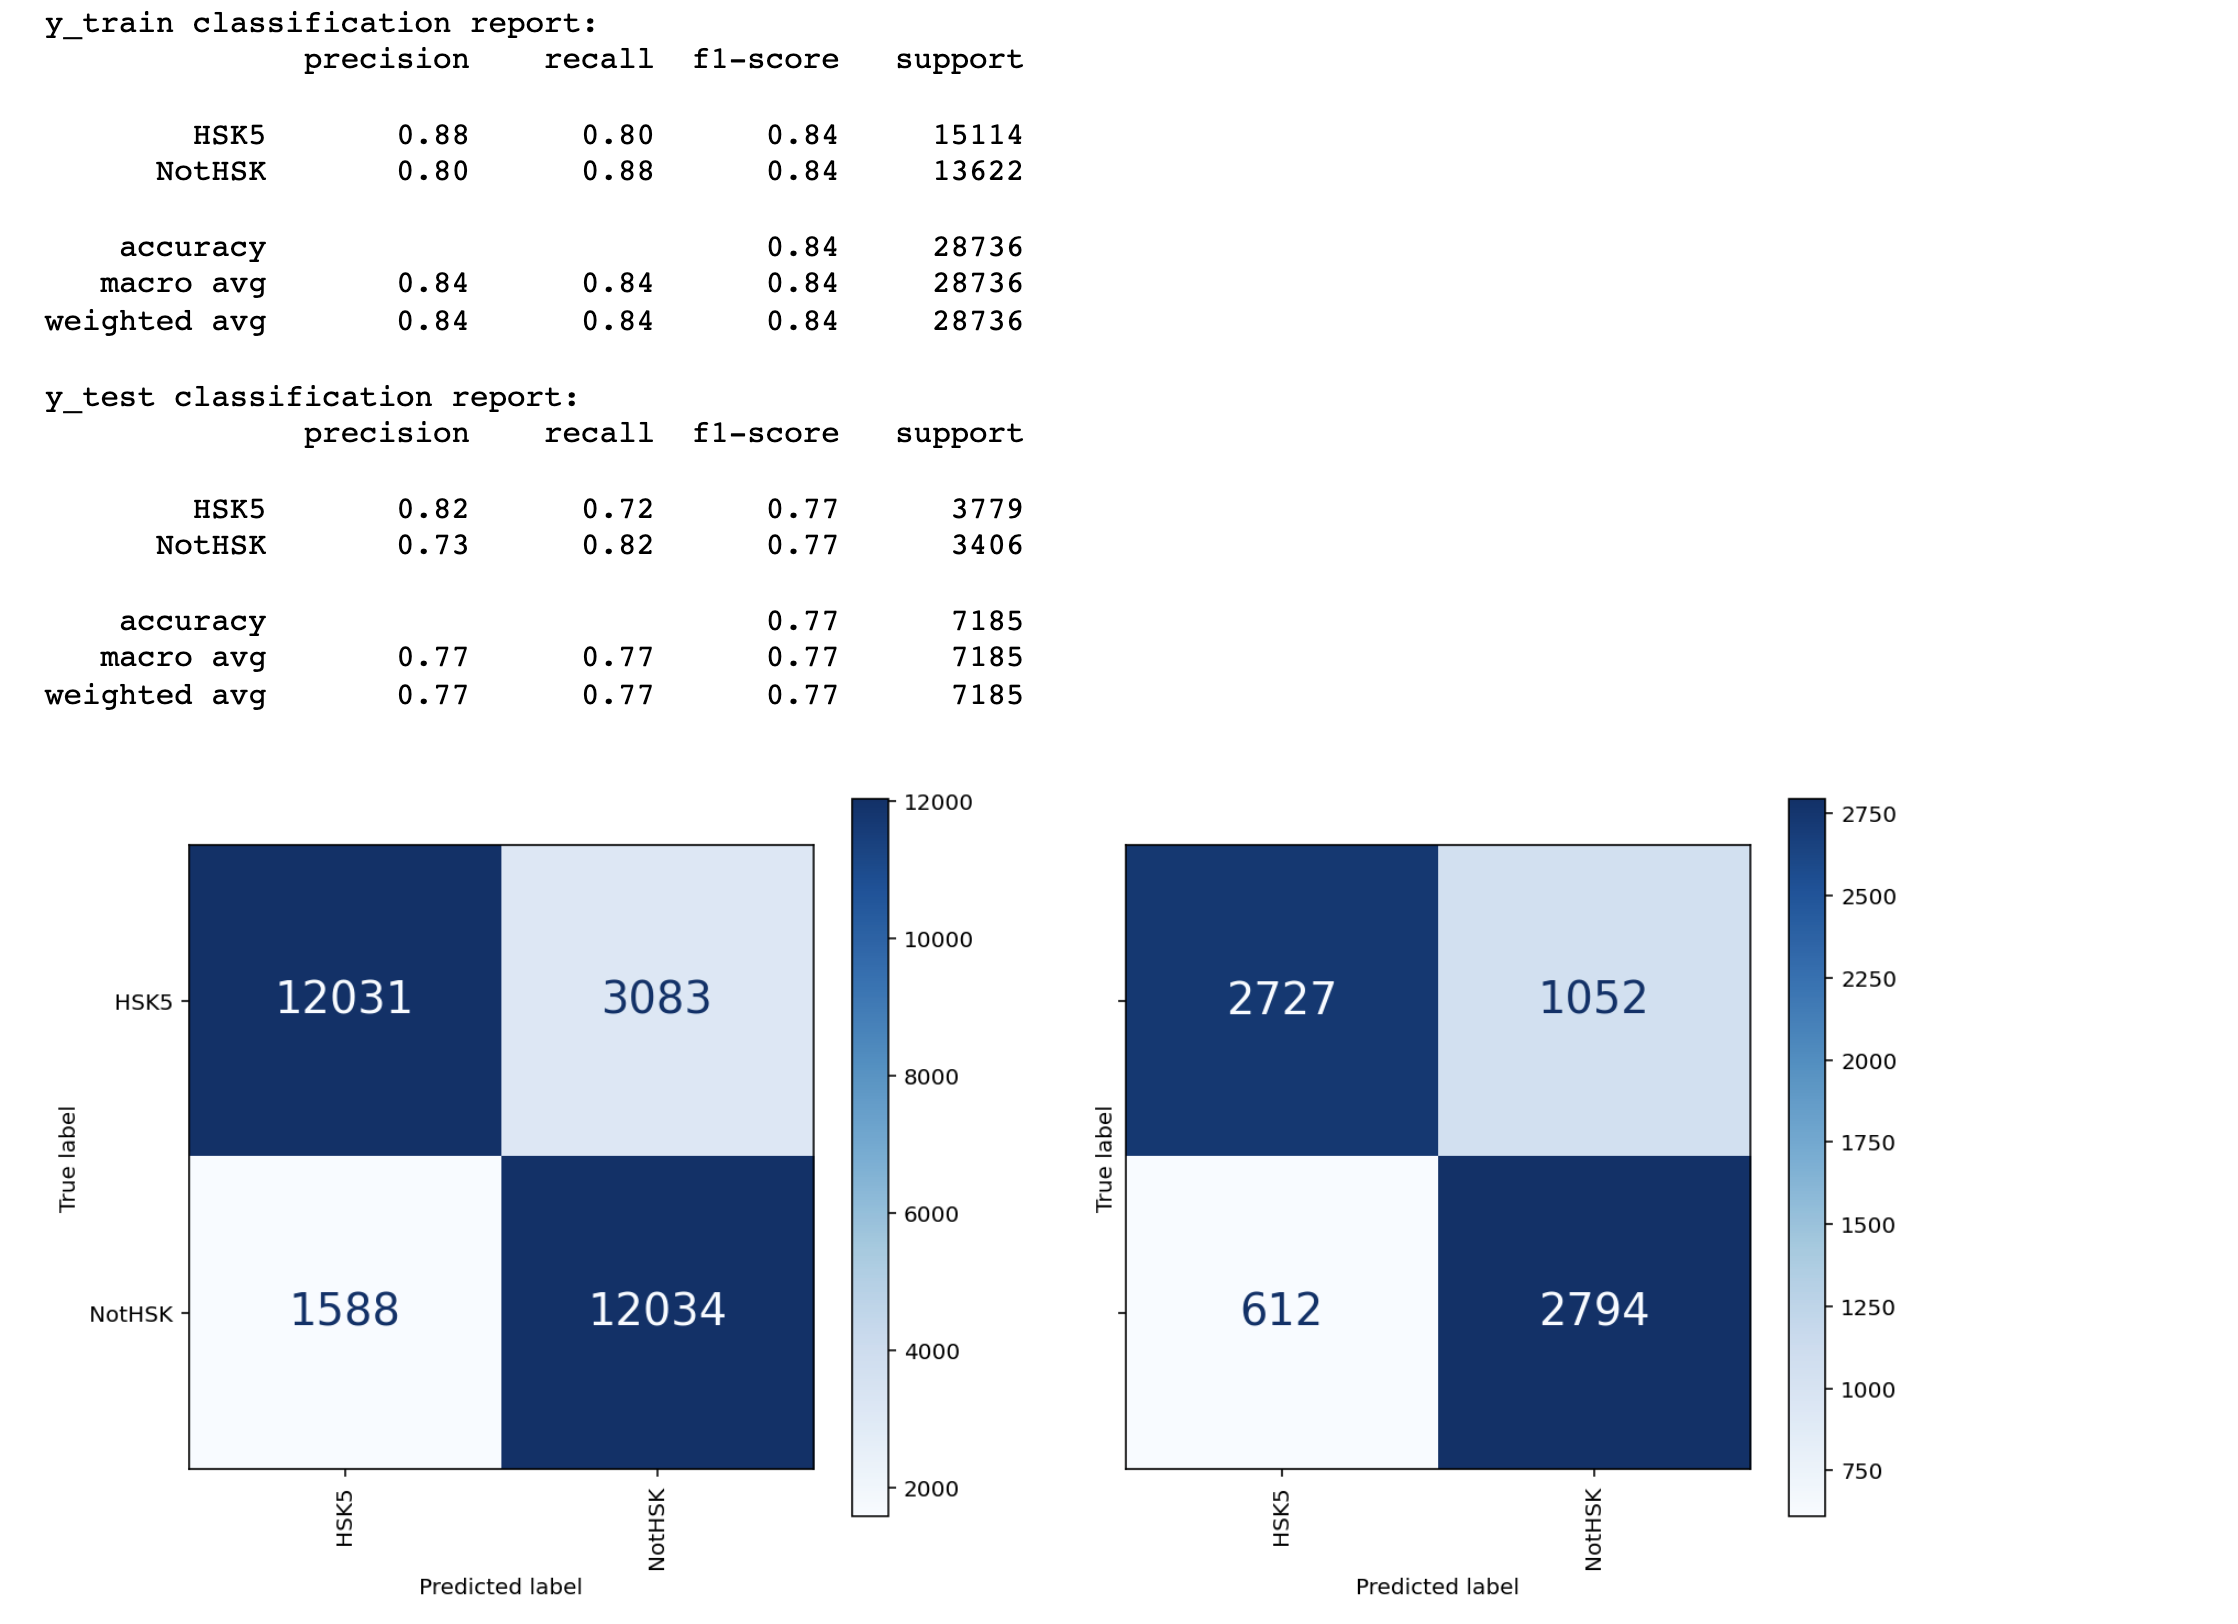

In [ ]:

# Tokenizer using JieBa to account for Mandarin
def snowtok(x):
    return SnowNLP(x).words

In [ ]:
# import data file
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
# Create HSK5 binary variable
df_h5 = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()
df_h5['is_h5'] = 'NotHSK'
df_h5['is_h5'][df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk5 > 0.9] = 'HSK5'
X = df_h5[['lyrics','is_h5'
]]
y = X.pop('is_h5')
X = X['lyrics']
df_h5['is_h5'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=snowtok, max_features=50000)
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)
X_train = cvec_mat
X_test = cvec.transform(X_test)

In [ ]:
params = {'solver':['adam'],
                'alpha':[10],
                'hidden_layer_sizes':[(20,20,20)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[500], 'verbose':[True],'warm_start':[True]}


skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_

In [ ]:
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

In [ ]:
logist_plots(gs,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

### 9.4. Multi Classification of HSK Based on Lyrics

#### 9.4.1. Try All Models

#### Fastest/Best Model:
- Training: 
- BernoulliNB(alpha=0.01)
- train time: 0.022s
- test time:  0.008s
- accuracy:   0.685
- dimensionality: 50000
- density: 1.000000
- top 10 keywords per class:
- 3: 一天 一起 世界 没 不会 走 不要 知道 没有 爱
- 4: 爱情 不要 不会 没 心 世界 知道 走 没有 爱
- 5: 梦 不会 太 走 混音 没 心 世界 没有 爱
- 6: 走 出 心 监制 录音 声 世界 吉他 爱 混音

- classification report:
confusion matrix:
- [[  98  118    9    1]
- [ 104 1628  680   16]
- [  48  921 3040  167]
- [  20   18  158  159]]
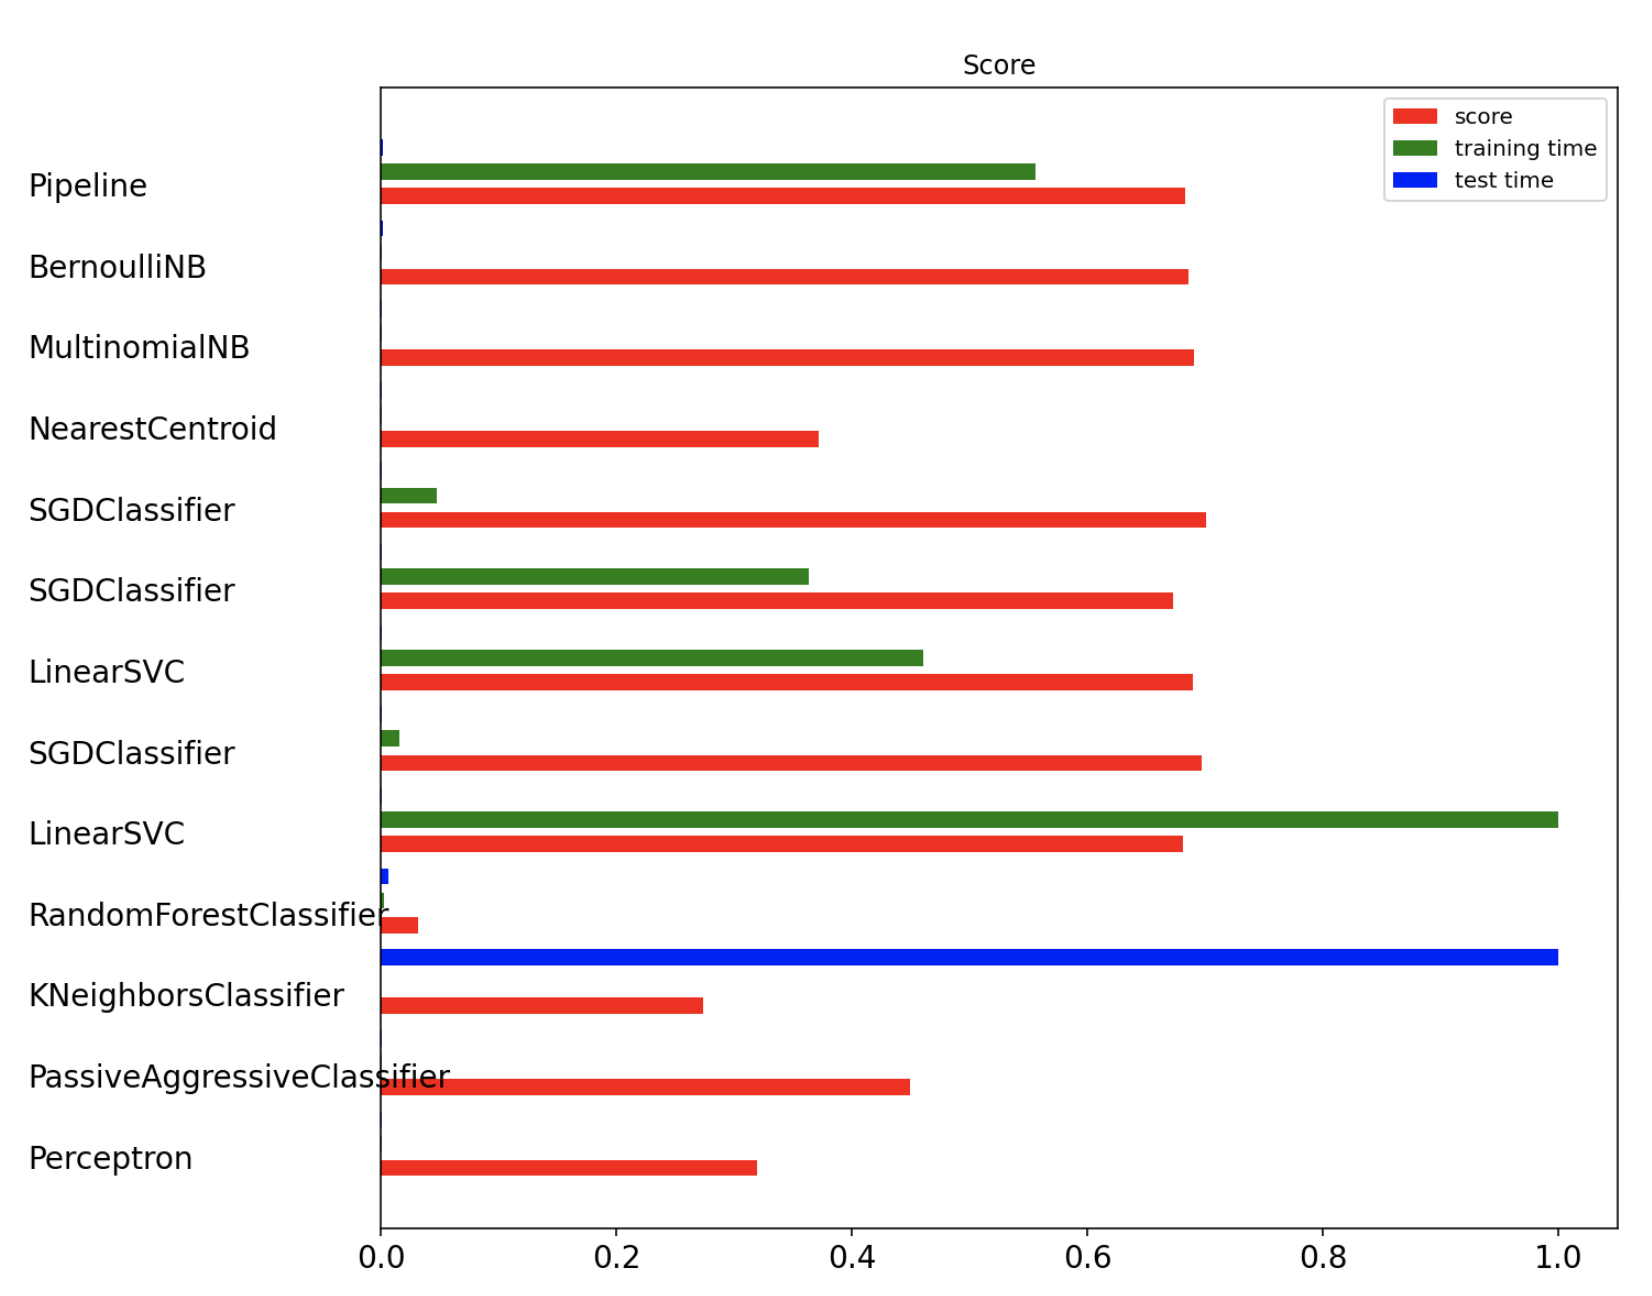



In [ ]:
# import data file
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
# Create X and y
df_HSK_classification = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()

X = df_HSK_classification[['lyrics','hsk_level'
]]

y = X.pop('hsk_level')
X=X['lyrics']


In [ ]:
def hsk3_group(x):
    if x <= 3:
        return 3
    else:
        return x

In [ ]:
y = y.apply(hsk3_group)

In [ ]:
y.value_counts()

In [ ]:
# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie)
cvec.fit(X)

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {3: np.round(1/1132), 4: np.round(1/12139), 5: np.round(1/20877), 6: np.round(1/1773) }

cvec = CountVectorizer(stop_words=updated_stopwords,
max_features=50000,
tokenizer=man_token_jie)





cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)


feature_names = np.array(cvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))
        try:
            if feature_names is not None:
                print("top 10 keywords per class:")
                for i, category in enumerate(set(y_train.values)):
                    top10 = np.argsort(clf.coef_[i])[-10:]
                    print((trim("%s: %s"
                                % (category, " ".join(feature_names[top10])))))
            print()
        except:
            pass
    print("classification report:")
    try:
        print((metrics.classification_report(y_test, pred,
                                         target_names=set(y_train.values))))
    except:
        pass
    try:
        print("confusion matrix:")
        print((metrics.confusion_matrix(y_test, pred)))

        print()
    except: 
        pass
    try:
        clf_descr = str(clf).split('(')[0]
    except:
        pass
    return clf_descr, score, train_time, test_time


results = []
for clf, name in ((Perceptron(max_iter=1000, tol=1e-3, class_weight=w, n_jobs=-1), "Perceptron"),(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight=w,n_jobs=-1), "Passive-Aggressive"),(KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),(RandomForestClassifier(n_estimators=100, class_weight=w, n_jobs=-1), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

#### 9.4.2. Grid Search on BernouliNB
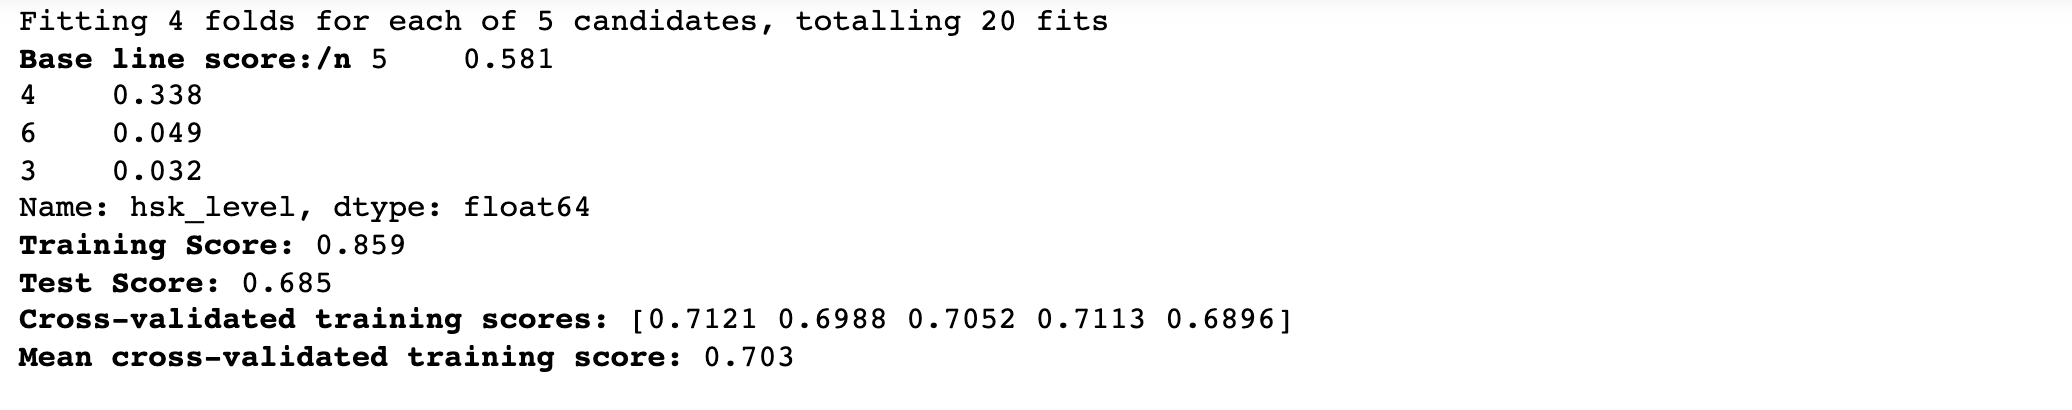
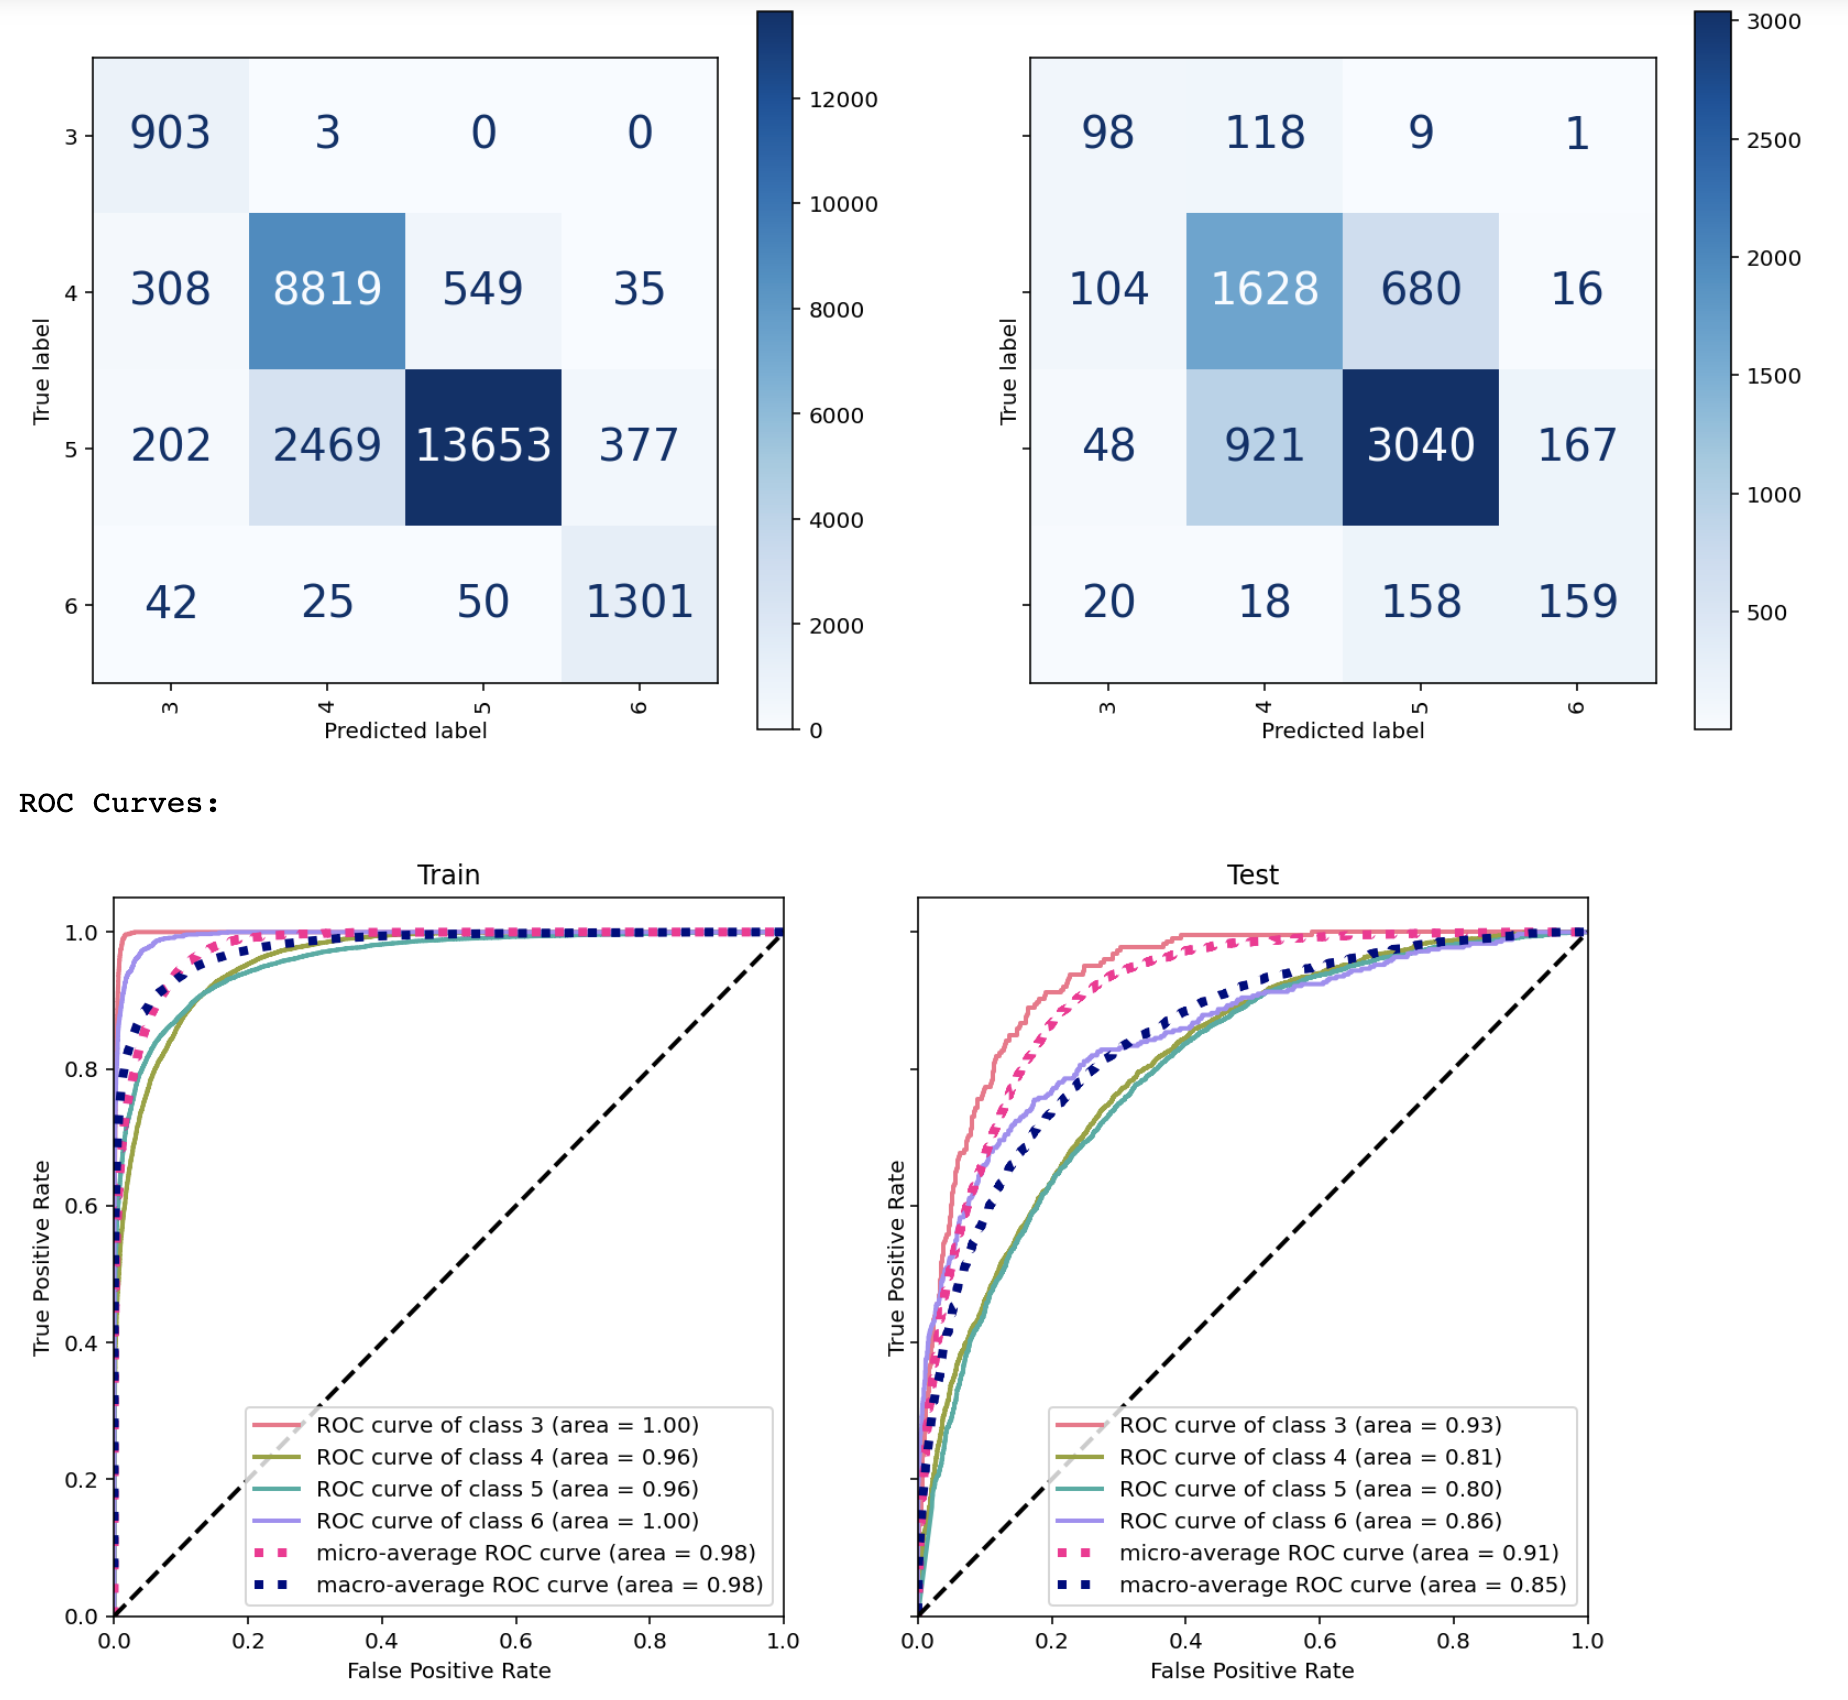

In [ ]:
# import data file
df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

In [ ]:
# Create X and y
df_HSK_classification = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()

X = df_HSK_classification[['lyrics','hsk_level'
]]

y = X.pop('hsk_level')
X = X['lyrics']


In [ ]:
def hsk3_group(x):
    if x <= 3:
        return 3
    elif x == 4:
        return 4
    elif x == 5:
        return 5
    elif x == 6:
        return 6

In [ ]:
y = y.apply(hsk3_group)

In [ ]:
y.value_counts()

In [ ]:
# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie)
cvec.fit(X)

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {3: np.round(1/1132), 4: np.round(1/12139), 5: np.round(1/20877), 6: np.round(1/1773) }

cvec = CountVectorizer(stop_words=updated_stopwords,
max_features=50000,
tokenizer=man_token_jie)





cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
# Get Train test split from sample data


params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
         }

skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X_train, y_train)

model = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=skf, verbose=5)

model.fit(X_train, y_train)


print(Bold + 'Base line score:/n' + Normal,
      np.round(y_train.value_counts(normalize=True), 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)


#### 9.4.4. TO RUN Neural Network modes: Multilayer Perceptron Feed-Forward network - activation: 'relu', Grid Search
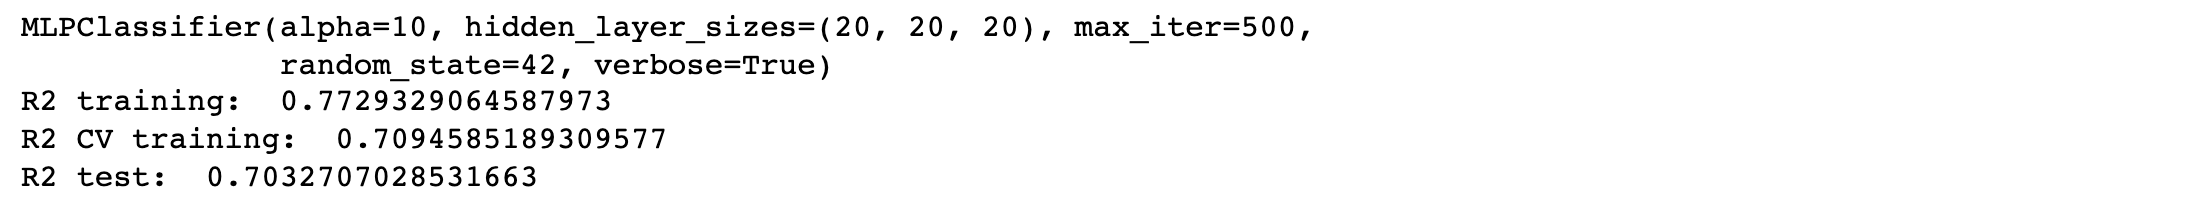

In [ ]:
from sklearn.model_selection import GridSearchCV
# Get Train test split from sample data

params = {'solver':['adam'],
                'alpha':[10],
                'hidden_layer_sizes':[(20,20,20)],
                'activation':['relu'],
                'random_state':[42],
                'batch_size':['auto'],
                'max_iter':[500], 'verbose':[True],'warm_start':[False]}


skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X_train, y_train)



gs = GridSearchCV(MLPClassifier(), param_grid=params, cv=skf, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

model = gs.best_estimator_

In [ ]:
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

### 9.3 Classification of Genre Based on Lyrics
#### Summary

Is it possible to classify genres based on Spotify lyrics?

I ran a train of classification models to try and identify the 5 largest genres based on song lyrics: (i) Cantopop (27%), (ii) Classic Mandopop (20%), (iii) Taiwan Pop (13%), and (iv) Mandopop (11%). To handle class imbalance I applied inverse class weights which proved to be effective. I used JieBa to tokenize the lyrics and TfidfVectorizer. I experimented with using updated stop words but the impact was neglible. The best score was from the BernoulliNB with a test score of 62.4% vs. a base lin of 36%. This was also one of the quickest models to run. 

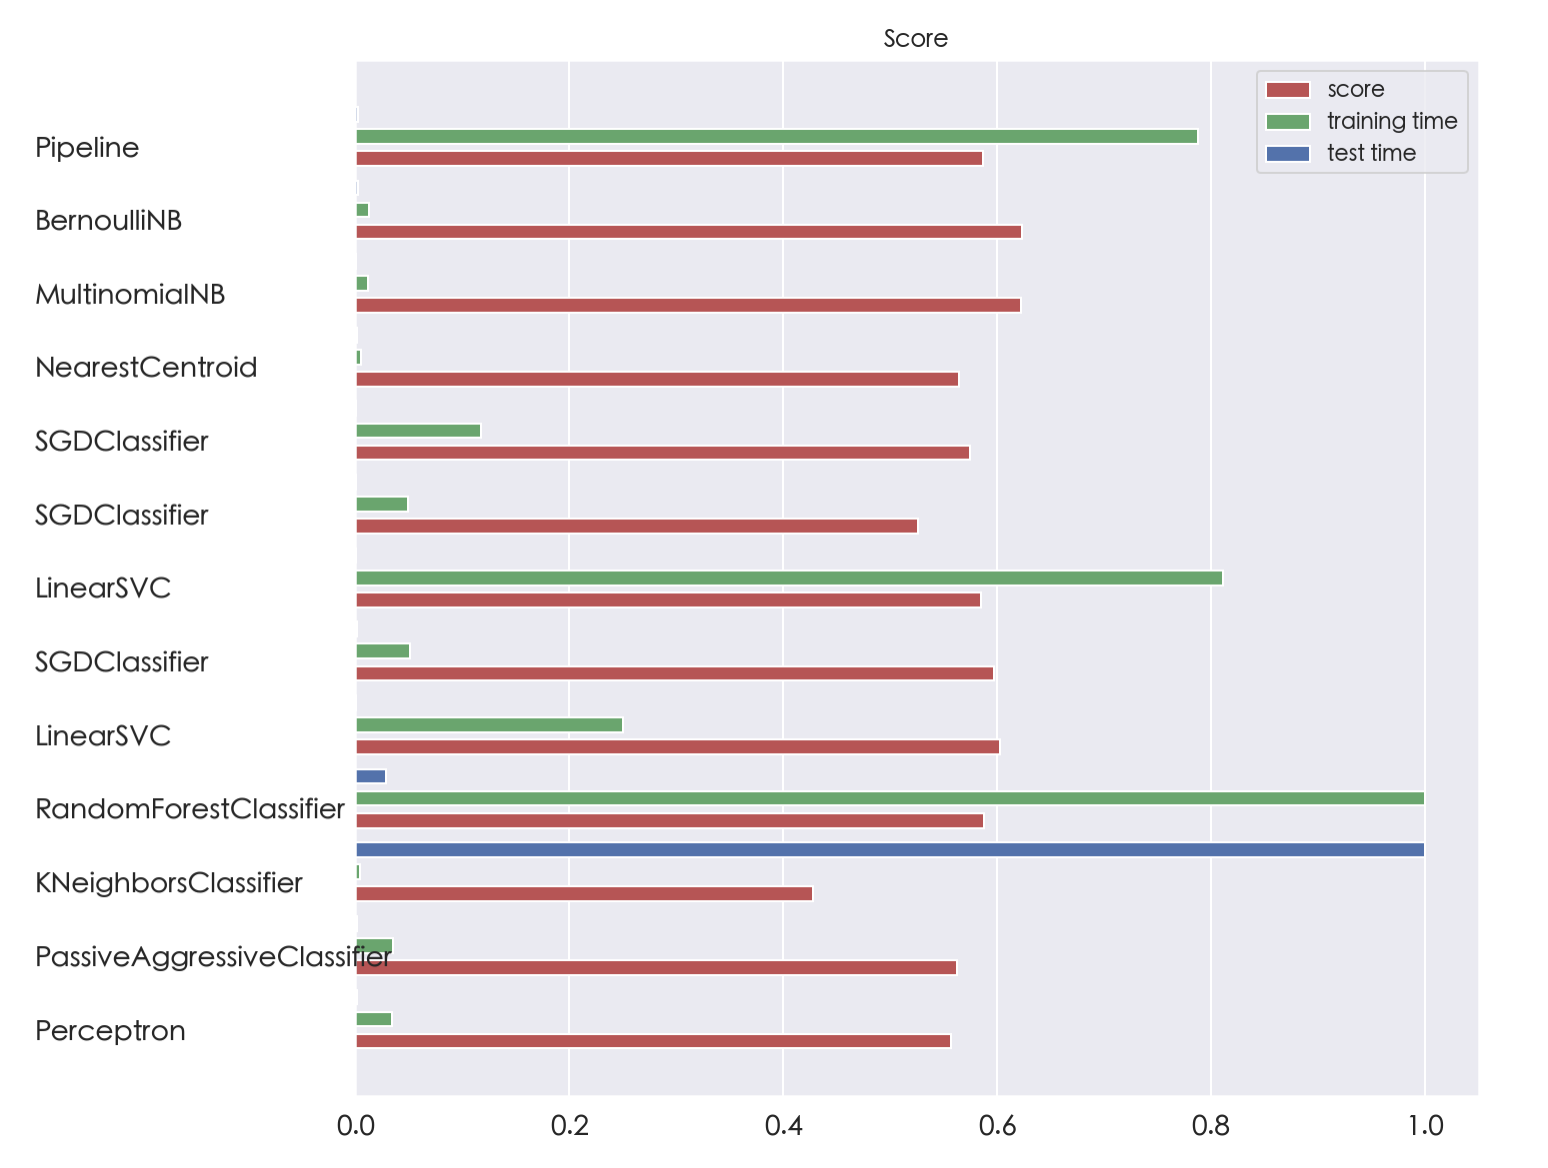


#### 9.3.1. Four Genres, TfidfVectorizer, Stop Words, Logistic Regression

Start off with top 5 genres:



In [ ]:
df_genres = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()

In [ ]:
df_genres.Genre2.value_counts(normalize=True)

In [ ]:
X = df_genres.lyrics[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]
y = df_genres.Genre2[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]

In [ ]:
X.shape, y.shape

In [ ]:
X.head()

In [ ]:
type(X)

In [ ]:
y.head()

In [ ]:
y.value_counts()

In [ ]:

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
# Create a customer tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
w = {'cantopop': 1/0.36, 'classic mandopop': 1/0.27,'taiwan pop': 1/0.18, 'mandopop': 1/0.14,'chinese indie': 1/0.05  }
model = make_pipeline(TfidfVectorizer(stop_words=stopwords(["zh"]),
                                      # sublinear_tf=True,
                                      max_df=0.3,
                                      max_features=1000,
                                      tokenizer=man_token_jie,
                                      norm='l2'),
                      LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight=w),
                      )



model.fit(X_train, y_train)

In [ ]:
Bold = '\033[1m'
Normal = '\033[0m'

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
lr_scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=6)

print(Bold + 'Base line score:' + Normal,
      np.round(y_train.value_counts(normalize=True)[0], 3))
print(Bold + 'Training Score:' + Normal, np.round(model.score(X_train, y_train),
                                                  3))
print(Bold + 'Test Score:' + Normal, np.round(model.score(X_test, y_test), 3))
print(Bold + "Cross-validated training scores:" + Normal,
      np.round(lr_scores, 4))
print(Bold + "Mean cross-validated training score:" + Normal,
      np.round(lr_scores.mean(), 3), '\n')

In [ ]:
logist_plots(model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

#### 9.3.2. Four Genres, TfidfVectorizer, Stop Words, All Models

In [ ]:
# Import Jieba to tokenize lyrics
import jieba.posseg as pseg
import jieba

In [ ]:
# Create a customer tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

In [ ]:
lyrics = df_tracks_master_clean3_lyrics_genre_hsk_v2.lyrics

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie)
cvec.fit(lyrics)
cvec.get_feature_names()[:5]

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

X = df_genres.lyrics[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]
y = df_genres.Genre2[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {'cantopop': np.round(1/0.36,2), 'classic mandopop': np.round(1/0.27),'taiwan pop': np.round(1/0.18), 'mandopop': np.round(1/0.14),'chinese indie': np.round(1/0.05)  }

tvec = TfidfVectorizer(stop_words=stopwords(["zh"]),
                                      max_df=0.3,
                                      max_features=50000,
                                      tokenizer=man_token_jie,
                                      norm='l2')




tvec.fit(X_train)
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)


feature_names = np.array(tvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(set(y_train.values)):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                            % (category, " ".join(feature_names[top10])))))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=set(y_train.values))))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
#         (RidgeClassifier(tol=1e-2, solver="sag", class_weight=w), "Ridge Classifier"),
        (Perceptron(max_iter=1000, tol=1e-3, class_weight=w, n_jobs=-1), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight=w,n_jobs=-1), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),
        (RandomForestClassifier(n_estimators=100, class_weight=w, n_jobs=-1), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

#### 9.3.3. Four Genres, TfidfVectorizer, Stop Words Updated, All Models

In [ ]:
# Import Jieba to tokenize lyrics
import jieba.posseg as pseg
import jieba

In [ ]:
# Create a customer tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

In [ ]:
lyrics = df_tracks_master_clean3_lyrics_genre_hsk_v2.lyrics

# Tokenize lyrics
cvec = CountVectorizer(tokenizer=man_token_jie)
cvec.fit(lyrics)
cvec.get_feature_names()[:5]

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

X = df_genres.lyrics[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]
y = df_genres.Genre2[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {'cantopop': np.round(1/0.36,2), 'classic mandopop': np.round(1/0.27),'taiwan pop': np.round(1/0.18), 'mandopop': np.round(1/0.14),'chinese indie': np.round(1/0.05)  }

tvec = TfidfVectorizer(stop_words=updated_stopwords,
max_df=0.3,
max_features=50000,
tokenizer=man_token_jie, norm='l2')





tvec.fit(X_train)
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)


feature_names = np.array(tvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(set(y_train.values)):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                            % (category, " ".join(feature_names[top10])))))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=set(y_train.values))))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in ((Perceptron(max_iter=1000, tol=1e-3, class_weight=w, n_jobs=-1), "Perceptron"),(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight=w,n_jobs=-1), "Passive-Aggressive"),(KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),(RandomForestClassifier(n_estimators=100, class_weight=w, n_jobs=-1), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

#### 9.3.4. Four Genres, TfidfVectorizer, Stop Words Updated (Again), All Models

#### 9.3.5. Word Vectorizer Models

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Facebook's Chinese word vectors.
fb_model = KeyedVectors.load_word2vec_format('/Users/stuart/Desktop/Spoty-Linguist-Project/wiki.zh/wiki.zh.vec')

In [ ]:
fb_model.most_similar(positive=[u'高'])

In [ ]:
# Import Jieba to tokenize lyrics
import jieba.posseg as pseg
import jieba

In [ ]:
# Create a customer tokenizer using JieBa to account for Mandarin
def man_token_jie(x):
    return jieba.lcut(x)

In [ ]:
import time
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier
# Load from the filename
word2vec_df = fb_model
#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(word2vec_df, y_train)
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

X = df_genres.lyrics[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]
y = df_genres.Genre2[(df_genres.Genre2 == 'cantopop') | (df_genres.Genre2 == 'classic mandopop') | (df_genres.Genre2 == 'taiwan pop') | (df_genres.Genre2 == 'mandopop') | (df_genres.Genre2 == 'chinese indie')]

# Get Train test split from sample data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

w = {'cantopop': np.round(1/0.36,2), 'classic mandopop': np.round(1/0.27),'taiwan pop': np.round(1/0.18), 'mandopop': np.round(1/0.14),'chinese indie': np.round(1/0.05)  }

tvec = TfidfVectorizer(stop_words=updated_stopwords_2,
max_df=0.3,
max_features=50000,
tokenizer=man_token_jie, norm='l2')





tvec.fit(X_train)
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)


feature_names = np.array(tvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(set(y_train.values)):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                            % (category, " ".join(feature_names[top10])))))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=set(y_train.values))))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in ((Perceptron(max_iter=1000, tol=1e-3, class_weight=w, n_jobs=-1), "Perceptron"),(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight=w,n_jobs=-1), "Passive-Aggressive"),(KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),(RandomForestClassifier(n_estimators=100, class_weight=w, n_jobs=-1), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

### 9.4. Unsupervised Classifiation Models to Identify Topics
Is it possible to identify topics using the lyrics. This could be useful to create playlists based on a topic a person is trying to learn. Clustering songs together based on common words or themes could also be helpful for people learning a new language as they would encounter similar words in each song. 

#### 9.4.1. KMeans TfidfVectorizer

In [ ]:
data = df_tracks_master_clean3_lyrics_genre_hsk_v2
lyrics = data.lyrics

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
tvec = TfidfVectorizer(stop_words=updated_stopwords,max_df=0.3,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)

# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = tvec.transform(lyrics)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

In [ ]:
# think of the X_matrix as mapping each song to a position in 10k dimensional space based on its lyrics
X_transformed.toarray().shape

In [ ]:
# the dimensions are based on the word features available
tvec.get_feature_names

In [ ]:
# for example if two songs both had 一则' and '一方面' they would be mapped to a similar dimensional space

In [ ]:
# these are the labels assigned to each of the 35k songs (60 labels)
modelkmeans.labels_

In [ ]:
# number of labels matches the number of songs
modelkmeans.labels_.shape

In [ ]:
# update the main dataframe so that labels can be seen
data['labels'] = modelkmeans.labels_

In [ ]:
data.head()

In [ ]:
# 254 songs in each category
data[data['labels'] == 1].lyrics.shape

In [ ]:
# now look at what are the most discerning features in each category

In [ ]:
# the first category (i.e. label 1)
# this is the matrix for all songs in category 1 (i.e. matrix mapping them to dimensional space)
tvec.transform(data[data['labels'] == 1].lyrics).toarray()

In [ ]:
group1 = pd.DataFrame(tvec.transform(data[data['labels'] == 1].lyrics).toarray(),columns =tvec.get_feature_names() )

In [ ]:
group1

In [ ]:
# as an example, looking at 鼻子 (nose)
# its weighting assigned is 0.0278
# if 鼻子 occurs in a song then that song is mapped to 鼻子 with weight 0.0278
# if it occurs twice that song is mapped to 鼻子 with 0.0278*2.
# higher weights indicate that the word mapping will be further from the centre
group1['鼻子'].value_counts()

In [ ]:
# the word with the greatest weighting accross all songs in this bucket is 再见 goodbye.
# it can be seen that 再见 has both the greatest weighting in this category (0.29) and also occurs the most frequently
# hence when summed accross songs has a value of 74. This weighting frequency holds up for all words.
print('Group1 words with greatest aggregate weighting:')
print(group1.sum().sort_values(ascending=False)[:30])
print('Group1 greatest weightings:')
print(group1.mean().sort_values(ascending=False)[:30])

In [ ]:
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish
# from each of the other 60 labels. 
topics = {}
for i in range(60):
#     display(pd.DataFrame(tvec.transform(data[data['labels']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:20])
    topics[i] = pd.DataFrame(tvec.transform(data[data['labels']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:20]

In [ ]:
# Initial Analysis of topics: 
# Lots of the same ideas coming out.

# POSTIVE sentiments:
#
# NEGATIVE sentiments:
# grief, fear, longing, 
# NEUTRAL sentiments:
# family / growing up, romance, moon/ stars/night, friendship, 

# japanese characters, cantonese characters, 

# # 0-2 vague: goodbye, time,
# 3: youth, flowers, lightness, 
# 4,5: negative feeling
# 6: lonely, taciturn. 
# 7: flying, freedom, sky,
# 8,9: slightly negative,
# 10: love
# 11: family and growing up,
# 12,14, 16, 19: music terminology should be deleted
# 13: dreams, spirituality
# 15: departing,
# 17: nothing
# 18: boys and girls, romance
# 20: through life,
# 21: love
# 22: happiness
# 23: moon, stars, night, twinkling 
# 24: nothing
# 25: grief
# 26: cantonese words (maybe these should be filtered out)
# 27: happiness
# 28: fear
# 29: nothing
# 30: nothing
# 31: nothing
# 32: romance
# 33: today, yesterday
# 34: negative feeling
# 35: tomorrow, yesterday,
# 36: nothing
# 37: side by side, together,
# 38: boys and girls love, 
# 39: mistakes
# 40: nothing much
# 41: sweet happy memories
# 42: wishing dreaming, 
# 43: not much
# 44: not much
# 45: words to be removed
# 46: flying heavens
# 47: friendship
# 48: not able to
# 49: boys and girls
# 50: nothing much
# 51: nothing much
# 52: nothing much
# 53: love
# 54: love
# 55: nothing much
# 56: nothing much
# 57: nothing much
# 58: together
# 59:  Japanese characters



topics

In [ ]:
group_all = pd.DataFrame(tvec.transform(data.lyrics).toarray(),columns =tvec.get_feature_names() )
group_all

In [ ]:
data[data['labels']==11].lyrics

In [ ]:
# next steps: 
# (1) some words need to be removed, such as music terminologies.
# then group songs into the major categories that were obvious. 
# 

# POSTIVE sentiments:
#
# NEGATIVE sentiments:
# grief, fear, longing, 
# NEUTRAL sentiments:
# family / growing up, romance, moon/ stars/night, friendship, 

# then run the model again on each of these sub categories to further divide.
# but first what happens if run the model for only two groups?
# or even 4 groups?
# also would i get better results if i reduced the max_df to something much smaller (currently at 30%)


In [ ]:
# update stop_words

additional_words_to_remove = {'录音室','处理','后期', '混音', '带','工程师','母带','师母','录音师', '声', '工程','编写', '录音','师', '助理', '弦乐', '吉他', '贝斯','配唱',
                              '鼓','混音', '录音', '弦乐','吉他', '声', '音乐', '贝斯','录音师', '母带', '编写', '人声', '录音室', '鼓', '工程师', '监制', '录音棚',
                              '师', '发行', '配唱', '带','唱', '一首歌', '听', '情歌', '歌', '首歌', '歌声', '出', '一首', '一起', '歌唱','歌', '一首', '唱', '写', '听', '情歌', '歌词', '没有', '首歌', '旋律', '一首歌', '快乐', '完', '这首', '曲'}



In [ ]:
updated_stopwords_3 = updated_stopwords.copy()
updated_stopwords_3.update(additional_words_to_remove)

In [ ]:
print(len(updated_stopwords_3))
print(len(updated_stopwords))

2 Clusters Only

In [ ]:
# splitting into just two categories didn't yield any interpretable resuls
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
tvec = TfidfVectorizer(stop_words=updated_stopwords_3,max_df=0.6,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)

# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = tvec.transform(lyrics)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=2, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

# update the main dataframe so that labels can be seen
data['labels_2_splits'] = modelkmeans.labels_
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish

# from each of the other 2 labels. 
topics2 = {}
for i in range(2):
    topics2[i] = pd.DataFrame(tvec.transform(data[data['labels']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:50]
    
topics2    
    

In [ ]:
topics2
    

In [ ]:
# Try 60 again but with max_df set at 5%
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
tvec = TfidfVectorizer(stop_words=updated_stopwords_3,max_df=0.05,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)

# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = tvec.transform(lyrics)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

# update the main dataframe so that labels can be seen
data['labels_60_splits_5%maxdf'] = modelkmeans.labels_
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish

# from each of the other 2 labels. 
topics3 = {}
for i in range(2):
    topics3[i] = pd.DataFrame(tvec.transform(data[data['labels']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:50]


In [ ]:
# from each of the other 2 labels. 
topics3 = {}
for i in range(60):
    topics3[i] = pd.DataFrame(tvec.transform(data[data['labels']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:50]
    

In [ ]:
topics3

In [ ]:
# Try 300 again but with max_df set at 5%
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
tvec = TfidfVectorizer(stop_words=updated_stopwords_3,max_df=0.3,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)

# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = tvec.transform(lyrics)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=300, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

# update the main dataframe so that labels can be seen
data['labels_300_splits_30%maxdf'] = modelkmeans.labels_
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish



In [ ]:
# from each of the other 2 labels. 
topics4 = {}
for i in range(300):
    topics4[i] = pd.DataFrame(tvec.transform(data[data['labels_300_splits_30%maxdf']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:10]
    

In [ ]:
topics4

In [ ]:
### 60 seems like a good starting point. Rerun on 60 at 30% as before but with additional stop words

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
tvec = TfidfVectorizer(stop_words=updated_stopwords_3,max_df=0.6,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)

# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = tvec.transform(lyrics)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

# update the main dataframe so that labels can be seen
data['labels_60_splits_30%maxdf_v2'] = modelkmeans.labels_
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish


# from each of the other 2 labels. 
topics5 = {}
for i in range(60):
    topics5[i] = pd.DataFrame(tvec.transform(data[data['labels_60_splits_30%maxdf_v2']==i].lyrics).toarray(), columns =tvec.get_feature_names()).sum().sort_values(ascending=False)[:10]
    
    

In [ ]:
topics5

In [ ]:
data3 = df_tracks_master_clean3_lyrics_genre_hsk_v2[df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk3 >= 0.9]
lyrics3 = data3.lyrics

In [ ]:
lyrics3.shape

In [ ]:
### 60 seems like a good starting point. Rerun on 60 at 30% as before but with additional stop words

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset

# fit the tvec on the 35k rows of lyrics, will take include the 10k top features in terms of scores. 
# Higher scores go to words that have more disciminating power. I.e. those that appear frequently in some documents,
# but occur relatively less freqently overall. 
cvec = CountVectorizer(stop_words=updated_stopwords_3,max_features=50000,tokenizer=man_token_jie)
cvec.fit(lyrics3)



In [ ]:

HSK3_lyrics_matrix = pd.DataFrame(cvec.transform(lyrics3).toarray(),columns =cvec.get_feature_names() )

In [ ]:
pd.options.display.max_rows = None
HSK3_lyrics_matrix.sum().sort_values(ascending=True)

In [ ]:
#### TO DO FIND CHARACTERS THAT ARENT IN HSK3,
#### THEN KEEP THESE AS FEATURES
#### THEN RUN CLASSIFIER BASED ON THIS SO THAT OUT OF HSK WORDS THAT OCCURS ACROSS MULTIPLE SONGS ARE GROUPED
for i in HSK3_lyrics_matrix.sum().sort_values(ascending=True):
    print(i)

In [ ]:
# as we fit on all lyrics, and we are transoforming the 35k lyric rows into a dataframe, all 10k features will occur
# at least once. 
X_transformed = cvec.transform(lyrics3)


# Consider X_transform each row is a vector, pointing to a position in 10k dimensional space.KMeans looks at these 
# points in 10k dimensional space and finds the 60 best centroids. 
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=10, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

# update the main dataframe so that labels can be seen
data3['labels'] = modelkmeans.labels_
# for each of the 60 labels, look at the words that were given the highest score in terms of their ability to distinguish


# from each of the other 2 labels. 
topics6 = {}
for i in range(10):
    topics6[i] = pd.DataFrame(cvec.transform(data3[data3['labels']==i].lyrics).toarray(), columns =cvec.get_feature_names()).sum().sort_values(ascending=False)[:40]
    
    

In [ ]:
# Check elbow up to k = 10
tvec = TfidfVectorizer(stop_words=updated_stopwords_2,max_df=0.3,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)
X_transformed = tvec.transform(lyrics)


modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)




distortions = []
K = range(1,10)
for k in K:
    modelkmeans = KMeans(n_clusters=k, init='k-means++', n_init=100)
    modelkmeans.fit(X_transformed)
    distortions.append(modelkmeans.inertia_)

In [ ]:
range(len(K)+1)

In [ ]:
old = distortions
old

In [ ]:
old.pop

In [ ]:
distortions = old[:9]

In [ ]:
test = [x for x in range(10)]

In [ ]:

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Check elbow for up to k = 100, stopwords 2
tvec = TfidfVectorizer(stop_words=updated_stopwords_2,max_df=0.3,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)
X_transformed = tvec.transform(lyrics)



distortions = []
K = range(1,100)
for k in tqdm(K):
    modelkmeans = KMeans(n_clusters=k, init='k-means++', n_init=100)
    modelkmeans.fit(X_transformed)
    distortions.append(modelkmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### 9.4.1. DBScan TfidfVectorizer

In [ ]:
# try DBScan
from sklearn import metrics
from sklearn.cluster import DBSCAN
data = df_tracks_master_clean3_lyrics_genre_hsk_v2
lyrics = data.lyrics



tvec = TfidfVectorizer(stop_words=updated_stopwords_2,max_df=0.3,max_features=10000,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)
X_transformed = tvec.transform(lyrics)



modeldbscan = DBSCAN(eps=0.05, min_samples=5)
modeldbscan.fit(X_transformed)



In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_transformed)
distances, indices = nbrs.kneighbors(X_transformed)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
tvec = TfidfVectorizer(stop_words=updated_stopwords_2,max_df=0.3,max_features=100,tokenizer=man_token_jie, norm='l2')
tvec.fit(lyrics)
X_transformed = tvec.transform(lyrics)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_transformed)
distances, indices = nbrs.kneighbors(X_transformed)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


Info here on how to optimze DBScan: 
- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
- https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27

#### 9.4.1. KMeans CVecVectorizer

In [ ]:
data = df_tracks_master_clean3_lyrics_genre_hsk_v2
lyrics = data.lyrics

In [ ]:
lyrics = data.lyrics

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset


cvec = CountVectorizer(stop_words=updated_stopwords,max_features=10000,tokenizer=man_token_jie)
cvec.fit(lyrics)
X_transformed = cvec.transform(lyrics)



from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

In [ ]:
cluster_labels = modelkmeans.labels_

In [ ]:
cluster_labels

In [ ]:
data['groupings'] = cluster_labels

In [ ]:
labels = cvec.get_feature_names()

In [ ]:
lyrics_mat = pd.DataFrame.sparse.from_spmatrix(X_transformed)
lyrics_mat.head()

In [ ]:
lyrics_mat.columns = labels

In [ ]:
data2 = pd.merge(data, lyrics_mat, left_index=True, right_index=True)

In [ ]:
data2.to_csv('df_tracks_master_clean3_lyrics_genre_hsk_v3.csv')

In [ ]:
data2.head()

In [ ]:
# # look at topics using original tvec
# topics = pd.DataFrame()
# for i in range(10):
#     display(pd.DataFrame(cvec.transform(data[data['labels']==i].lyrics).toarray(), columns =cvec.get_feature_names()).sum().sort_values(ascending=False)[:15])


In [ ]:
# # look at topics but recalibrating tvec on each new sub cluster
# topics = pd.DataFrame()
# for i in range(10):
#     display(pd.DataFrame(cvec.fit_transform(data[data['labels']==i].lyrics).toarray(), columns =cvec.get_feature_names()).sum().sort_values(ascending=False)[:15])


## 10. Playlist generation

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v3 = pd.read_csv(
    '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
    sep=',',
    index_col=0)

#### 10.1. Player

In [ ]:
### Version 1
from ipywidgets import GridspecLayout
from ipywidgets import AppLayout, Button, Layout
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
# import IPython.display 
import urllib.request
from PIL import Image
from IPython.display import clear_output

########## HSK Selection
# default HSK Choice

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(3, 3)

def HSK1_button(x):
    global HSK_choice
    HSK_choice = 1
    return HSK_choice

def HSK2_button(x):
    global HSK_choice
    HSK_choice = 2
    return HSK_choice

def HSK3_button(x):
    global HSK_choice
    HSK_choice = 3
    return HSK_choice

def HSK4_button(x):
    global HSK_choice
    HSK_choice = 4
    return HSK_choice

def HSK5_button(x):
    global HSK_choice
    HSK_choice = 5
    print(5)
    return HSK_choice

def HSK6_button(x):
    global HSK_choice
    HSK_choice = 6
    return HSK_choice  

grid[0,0] = create_expanded_button('HSK 1', 'info')
grid[0,0].on_click(HSK1_button)

grid[0,1] = create_expanded_button('HSK 2', 'info')
grid[0,1].on_click(HSK2_button)

grid[0,2] = create_expanded_button('HSK 3', 'success')
grid[0,2].on_click(HSK3_button)

grid[1,0] = create_expanded_button('HSK 4', 'success')
grid[1,0].on_click(HSK4_button)

grid[1,1] = create_expanded_button('HSK 5', 'warning')
grid[1,1].on_click(HSK5_button)

grid[1,2] = create_expanded_button('HSK 6', 'danger')
grid[1,2].on_click(HSK6_button)


###### Album Cover
img1 = open('gfg.png', 'rb').read()
wi1 = widgets.Image(value=img1, format='png', width=300, height=400)

# Genre
checkbox_genre = widgets.RadioButtons(options=df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()].unique()[:10], value = 'mandopop', description='Genre')

# Play Button
play_button = widgets.Button(description="Play Song")
create_play_list_button = widgets.Button(description="Create Playlist")

talk_slider = widgets.FloatSlider(
    value=80,
    min=0,
    max=100.0,
    step=0.1,
    description='Talkability',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

tempo_slider = widgets.FloatSlider(
    value=80,
    min=0,
    max=100.0,
    step=0.1,
    description='Tempo',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)


grid_master = GridspecLayout(4, 20, height='500px')

grid_master[0,0:7] = grid
grid_master[0,12:20] = wi1
grid_master[0,7:10] = checkbox_genre
grid_master[1,0:7] = talk_slider
grid_master[2,0:7] = tempo_slider
grid_master[3,0:7] = play_button
grid_master[3,8:] = create_play_list_button

play_button.on_click(on_button_clicked)



display(grid_master)

def on_button_clicked(b):
    clear_output(wait=True)
    
    songs_found = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].shape[0]
    song_randomizer = random.randint(1, songs_found)
    
    img1 = open('gfg.png', 'rb').read()
    wi1 = widgets.Image(value=img1, format='png', width=300, height=400)


    
    
#     grid_master = GridspecLayout(20, 20)

#     grid_master[0,0:7] = grid
#     grid_master[0,12:20] = wi1
#     grid_master[0,7:10] = hkbox_genre
#     grid_master[1,0:7] = play_button
    
#     display(grid_master)
    
    urllib.request.urlretrieve(df_tracks_master_clean3_lyrics_genre_hsk_v3.iloc[song_randomizer,16],"gfg.png")

    ## Read images from file (because this is binary, maybe you can find how to use ByteIO) but this is more easy
#     ## Side by side thanks to HBox widgets
#     sidebyside = widgets.HBox([wi1])
#     ## Finally, show.
#     display(sidebyside)   
    grid_master = GridspecLayout(4, 20, height='500px')
    
    grid_master[0,0:7] = grid
    grid_master[0,12:20] = wi1
    grid_master[0,7:10] = checkbox_genre
    grid_master[1,0:7] = talk_slider
    grid_master[2,0:7] = tempo_slider
    grid_master[3,0:7] = play_button
    grid_master[3,8:] = create_play_list_button
    
    display(grid_master)
    song_selection_href = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,8]

    song_selection = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,0]
    artist_selection = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,2]
    print('HSK Level:',HSK_choice )
    print('Number of songs found:', songs_found)
    print('Playing:',song_selection)
    print('Artist:',artist_selection )
    print('Track Name', song_selection)
    
    try:
        pull_lyrics(song_selection, song_selection_href)
    except:
        print('lyrics not avaiable')
    
    
    


In [ ]:
def getChinese(context):
    filtrate = re.compile(u'[^\u4E00-\u9FA5]')  # non-Chinese unicode range
    context = filtrate.sub(r'', context)  # remove all non-Chinese characters
    return context
    

def song_uri_from_href(href):
    try: 
        url_search = re.compile(r'(?<=track/).*(?=.*?\?)')
        result = re.findall(url_search, href)[0]
        uri = 'spotify:track:' + result
        return uri
    except:
        url_search = re.compile(r'(?<=tracks/).*')
        result = re.findall(url_search, href)[0]
        uri = 'spotify:track:' + result
        return uri


def pull_lyrics(table_name, href):
    
    # first filter tablename variable for only chinese characters
    
    try:
        table_name = getChinese(table_name)

        song_uri = song_uri_from_href(href)
        print('Starting Playback')
        print('Lyrics')
        sp.start_playback(device_id=device_id, uris=[song_uri])

        # pull lyric table from data base and convert time to time format
        db_connection = sqlite3.connect('/Users/stuart/Desktop/Spoty-Linguist-Project/master_sql_db.db.sqlite')
        sql_lyrics_table = sql.read_sql('SELECT time, lyrics FROM %s'%table_name, con = db_connection)
        sql_lyrics_table['time'] = sql_lyrics_table.time.apply(pd.to_datetime)

        # create a column that include time between each lyrics
        sql_lyrics_table['pause_time'] = sql_lyrics_table.time
        time_temp = sql_lyrics_table.pause_time[0] # start time
        for ind,i in enumerate(sql_lyrics_table.pause_time):
            sql_lyrics_table.iloc[ind,2] = sql_lyrics_table.iloc[ind,0] - time_temp
            time_temp = sql_lyrics_table.time[ind]

        for ind,i in enumerate(sql_lyrics_table.lyrics):
            print(i)
            time.sleep(sql_lyrics_table.pause_time[ind].total_seconds()/60)


        sp.pause_playback(device_id=device_id)
        
    except:
        print('lyrics not available')
        time.sleep(3)
        sp.pause_playback(device_id=device_id)
    

In [ ]:
# df_tracks_master_clean3_lyrics_genre_hsk_v3 = data2

### Version 2
from ipywidgets import GridspecLayout
from ipywidgets import AppLayout, Button, Layout
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
# import IPython.display 
import urllib.request
from PIL import Image
from IPython.display import clear_output

########## HSK Selection
# default HSK Choice

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(3, 3)

def HSK1_button(x):
    global HSK_choice
    HSK_choice = 1
    return HSK_choice

def HSK2_button(x):
    global HSK_choice
    HSK_choice = 2
    return HSK_choice

def HSK3_button(x):
    global HSK_choice
    HSK_choice = 3
    return HSK_choice

def HSK4_button(x):
    global HSK_choice
    HSK_choice = 4
    return HSK_choice

def HSK5_button(x):
    global HSK_choice
    HSK_choice = 5
    print(5)
    return HSK_choice

def HSK6_button(x):
    global HSK_choice
    HSK_choice = 6
    return HSK_choice  

grid[0,0] = create_expanded_button('HSK 1', 'info')
grid[0,0].on_click(HSK1_button)

grid[0,1] = create_expanded_button('HSK 2', 'info')
grid[0,1].on_click(HSK2_button)

grid[0,2] = create_expanded_button('HSK 3', 'success')
grid[0,2].on_click(HSK3_button)

grid[1,0] = create_expanded_button('HSK 4', 'success')
grid[1,0].on_click(HSK4_button)

grid[1,1] = create_expanded_button('HSK 5', 'warning')
grid[1,1].on_click(HSK5_button)

grid[1,2] = create_expanded_button('HSK 6', 'danger')
grid[1,2].on_click(HSK6_button)


###### Album Cover
img1 = open('gfg.png', 'rb').read()
wi1 = widgets.Image(value=img1, format='png', width=300, height=400)

# Genre
checkbox_genre = widgets.RadioButtons(options=df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()].unique()[:10], value = 'mandopop', description='Genre')

# Play Button
play_button = widgets.Button(description="Play Song")
create_play_list_button = widgets.Button(description="Create Playlist")


grid_master = GridspecLayout(4, 20, height='500px')

grid_master[0,0:7] = grid
grid_master[0,12:20] = wi1
grid_master[0,7:10] = checkbox_genre
grid_master[3,0:7] = play_button
grid_master[3,8:] = create_play_list_button

play_button.on_click(on_button_clicked)



display(grid_master)



def on_button_clicked(b):
    clear_output(wait=True)
    
    songs_found = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].shape[0]
    song_randomizer = random.randint(1, songs_found)
    
    img1 = open('gfg.png', 'rb').read()
    wi1 = widgets.Image(value=img1, format='png', width=300, height=400)


    
    
#     grid_master = GridspecLayout(20, 20)

#     grid_master[0,0:7] = grid
#     grid_master[0,12:20] = wi1
#     grid_master[0,7:10] = hkbox_genre
#     grid_master[1,0:7] = play_button
    
#     display(grid_master)
    
    urllib.request.urlretrieve(df_tracks_master_clean3_lyrics_genre_hsk_v3.iloc[song_randomizer,16],"gfg.png")

    ## Read images from file (because this is binary, maybe you can find how to use ByteIO) but this is more easy
#     ## Side by side thanks to HBox widgets
#     sidebyside = widgets.HBox([wi1])
#     ## Finally, show.
#     display(sidebyside)   
    grid_master = GridspecLayout(4, 20, height='500px')
    
    grid_master[0,0:7] = grid
    grid_master[0,12:20] = wi1
    grid_master[0,7:10] = checkbox_genre
    grid_master[3,0:7] = play_button
    grid_master[3,8:] = create_play_list_button
    
    display(grid_master)
    song_selection_href = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,8]

    song_selection = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,0]
    artist_selection = df_tracks_master_clean3_lyrics_genre_hsk_v3[(df_tracks_master_clean3_lyrics_genre_hsk_v3['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'][df_tracks_master_clean3_lyrics_genre_hsk_v3['Genre2'].notnull()] == checkbox_genre.value)].iloc[song_randomizer,2]
    print('HSK Level:',HSK_choice )
    print('Number of songs found:', songs_found)
    print('Playing:',song_selection)
    print('Artist:',artist_selection )
    print('Track Name', song_selection)
    
    try:
        pull_lyrics(song_selection, song_selection_href)
    except:
        print('lyrics not avaiable')
    
    
    


#### 10.2. Redundant

In [ ]:
# # import data file
# df_tracks_master_clean3_lyrics_genre_hsk_v2 = pd.read_csv(
#     '/Users/stuart/Desktop/Spoty-Linguist-Project/df_tracks_master_clean3_lyrics_genre_hsk_v2.csv',
#     sep=',',
#     index_col=0)

In [ ]:
# import ipywidgets as widgets
# from ipywidgets import TwoByTwoLayout
# # import IPython.display 
# import urllib.request
# from PIL import Image
# from IPython.display import clear_output



# # chkbox_hsk = widgets.RadioButtons(options=df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'].unique(), value = 4,
# #  description='HSK Level')

# # chkbox_genre = widgets.RadioButtons(options=df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'].unique()[:10], value = 'mandopop',
# #  description='Genre')


# # button = widgets.Button(description="Play Song")


# def on_button_clicked(b):
#     songs_found = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].shape[0]
#     song_randomizer = random.randint(1, songs_found)
    
#     clear_output(wait=True)
#     display(button)
#     display(chkbox_hsk, chkbox_genre)


#     urllib.request.urlretrieve(df_tracks_master_clean3_lyrics_genre_hsk_v2.iloc[song_randomizer,16],"gfg.png")

#     ## Read images from file (because this is binary, maybe you can find how to use ByteIO) but this is more easy
#     img1 = open('gfg.png', 'rb').read()
#     wi1 = widgets.Image(value=img1, format='png', width=300, height=400)
# #     ## Side by side thanks to HBox widgets
# #     sidebyside = widgets.HBox([wi1])
# #     ## Finally, show.
# #     display(sidebyside)   
#     layout = TwoByTwoLayout(top_left=chkbox_hsk,
#                bottom_left=genre1_drop,
#                bottom_right=wi1)
    
#     display(layout)
#     song_selection_href = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,8]

#     song_selection = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,0]
#     artist_selection = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,2]
    
#     print('Number of songs found:', songs_found)
#     print('Playing:',song_selection)
#     print('Artist:',artist_selection )
#     print('Track Name', song_selection)
    
#     try:
#         pull_lyrics(song_selection, song_selection_href)
#     except:
#         print('lyrics not avaiable')
    




# button.on_click(on_button_clicked)

# img1 = open('gfg.png', 'rb').read()
# wi1 = widgets.Image(value=img1, format='png', width=300, height=400)


# layout = TwoByTwoLayout(top_left=grid,
#            bottom_left=genre1_drop,
#            bottom_right=wi1)




# display(layout)

In [ ]:
from ipywidgets import GridspecLayout
from ipywidgets import AppLayout, Button, Layout
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
# import IPython.display 
import urllib.request
from PIL import Image
from IPython.display import clear_output

########## HSK Selection
# default HSK Choice
HSK_choice = 5 
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(4, 3)

def HSK1_button(x):
    HSK_choice = 1
    return HSK_choice

def HSK2_button(x):
    HSK_choice = 2
    return HSK_choice

def HSK3_button(x):
    HSK_choice = 3
    return HSK_choice

def HSK4_button(x):
    HSK_choice = 4
    return HSK_choice

def HSK5_button(x):
    HSK_choice = 5
    return HSK_choice

def HSK6_button(x):
    HSK_choice = 6
    return HSK_choice  

grid[0,0] = create_expanded_button('HSK 1', 'info')
grid[0,0].on_click(HSK1_button)

grid[0,1] = create_expanded_button('HSK 2', 'info')
grid[0,1].on_click(HSK2_button)

grid[0,2] = create_expanded_button('HSK 3', 'success')
grid[0,2].on_click(HSK3_button)

grid[1,0] = create_expanded_button('HSK 4', 'success')
grid[1,0].on_click(HSK4_button)

grid[1,1] = create_expanded_button('HSK 5', 'warning')
grid[1,1].on_click(HSK5_button)

grid[1,2] = create_expanded_button('HSK 6', 'danger')
grid[1,2].on_click(HSK6_button)

grid[1,2] = create_expanded_button('HSK 6', 'danger')
grid[1,2].on_click(HSK6_button)

###### Album Cover
img1 = open('gfg.png', 'rb').read()
wi1 = widgets.Image(value=img1, format='png', width=300, height=400)

# Genre
checkbox_genre = widgets.RadioButtons(options=df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'].unique()[:10], value = 'mandopop', description='Genre')

# Play Button
play_button = widgets.Button(description="Play Song")

grid_master = GridspecLayout(2, 20)

grid_master[0,0:7] = grid
grid_master[0,12:20] = wi1
grid_master[0,7:10] = checkbox_genre
grid_master[1,0:7] = play_button

play_button.on_click(on_button_clicked)

display(grid_master)

def on_button_clicked(b):
    clear_output(wait=True)
    
    songs_found = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == HSK_choice) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == checkbox_genre.value)].shape[0]
    song_randomizer = random.randint(1, songs_found)
    
    img1 = open('gfg.png', 'rb').read()
    wi1 = widgets.Image(value=img1, format='png', width=300, height=400)


    
    
#     grid_master = GridspecLayout(20, 20)

#     grid_master[0,0:7] = grid
#     grid_master[0,12:20] = wi1
#     grid_master[0,7:10] = hkbox_genre
#     grid_master[1,0:7] = play_button
    
#     display(grid_master)
    
    urllib.request.urlretrieve(df_tracks_master_clean3_lyrics_genre_hsk_v2.iloc[song_randomizer,16],"gfg.png")

    ## Read images from file (because this is binary, maybe you can find how to use ByteIO) but this is more easy
#     ## Side by side thanks to HBox widgets
#     sidebyside = widgets.HBox([wi1])
#     ## Finally, show.
#     display(sidebyside)   
#     grid_master = GridspecLayout(20, 20)
    
    grid_master = GridspecLayout(2, 20)
    grid_master[0,0:7] = grid
    grid_master[0,12:20] = wi1
    grid_master[0,7:10] = checkbox_genre
    grid_master[1,0:7] = play_button
    
    display(grid_master)
    song_selection_href = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,8]

    song_selection = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,0]
    artist_selection = df_tracks_master_clean3_lyrics_genre_hsk_v2[(df_tracks_master_clean3_lyrics_genre_hsk_v2['hsk_level'] == chkbox_hsk.value) & (df_tracks_master_clean3_lyrics_genre_hsk_v2['Genre2'] == chkbox_genre.value)].iloc[song_randomizer,2]
    
    print('Number of songs found:', songs_found)
    print('Playing:',song_selection)
    print('Artist:',artist_selection )
    print('Track Name', song_selection)
    
    try:
        pull_lyrics(song_selection, song_selection_href)
    except:
        print('lyrics not avaiable')
    
    
    


How to add buttons in Jupyter
- https://medium.com/convergence-tech/ux-in-jupyter-user-input-essentials-779c9b449f2d

In [ ]:
widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False
)

## 11. Network Generator

In [ ]:
df_tracks_master_clean3_lyrics_genre_hsk_v2[df_tracks_master_clean3_lyrics_genre_hsk_v2.hsk1 > 0.7]

In [ ]:
start = df_tracks_master_clean3_lyrics_genre_hsk_v2.loc[1088].lyrics
start

In [ ]:
list(set(SnowNLP(start).words))

In [ ]:
df_test = df_tracks_master_clean3_lyrics_genre_hsk_v2.copy()

In [ ]:
def characters(x):
    return list(set(SnowNLP(x).words))
    

In [ ]:
df_test['character_unique'] = df_test.lyrics

In [ ]:
df_test['character_unique'] = df_test['character_unique'].apply(characters)

In [ ]:
df_test.loc[0].lyrics

In [ ]:
df_test[df_test.hsk_level == 1].shape

In [ ]:
df_hsk2 = df_test[df_test.hsk_level == 2]

In [ ]:
df_hsk2 = df_hsk2.sort_values(by='hsk2', ascending=False)

In [ ]:
start = df_hsk2.character_unique.iloc[0]

Start

In [ ]:
calc_df = df_test.copy()

In [ ]:
# Create calc column
calc_df['calc'] = calc_df['character_unique']

In [ ]:

# create Branch column
calc_df['branch'] = 0

# create Node column
calc_df['node'] = 0

# create Previous Branch
calc_df['prev_branch'] = 0

# Cumulative characters
calc_df['cumulative_characters'] = 0

In [ ]:
song_order = pd.DataFrame()

In [ ]:
branch = 0

In [ ]:
node = 0

In [ ]:
prev_branch = 0

In [ ]:
# get starting song
calc_df = calc_df.sort_values(by='hsk1', ascending=False)

In [ ]:
# Calculate scores of all songs with comparison to fist song
comparable = calc_df['calc'].iloc[0]
for ind,i in enumerate(calc_df['calc']):
    calc_df['calc'].iloc[ind] = len(i) - len(set.intersection(set(comparable),set(i)))
calc_df = calc_df.sort_values(by=['calc', 'hsk3'])

In [ ]:
#next closest song (row 1 is the original song)
calc_df.sort_values(by=['calc', 'hsk3']).iloc[1]

In [ ]:
calc_df['cumulative_characters'].iloc[0] = len(calc_df.character_unique.iloc[0])
calc_df['branch'].iloc[0] = branch
calc_df['node'].iloc[0] = node
previous_branch = 0
calc_df['prev_branch'].iloc[0] = previous_branch

In [ ]:
# put first song into song order
song_order = song_order.append(calc_df.iloc[0])

In [ ]:
cumulative_characters = len(calc_df.character_unique.iloc[0])
previous_branch = 0

In [ ]:
# remove first song from dataframe
calc_df = calc_df.iloc[1:]

Repeat

In [ ]:
# Create calc column
calc_df['calc'] = calc_df['character_unique']

In [ ]:
# Calculate scores of all songs with comparison to fist song
comparable = calc_df['calc'].iloc[0]
for ind,i in enumerate(calc_df['calc']):
    calc_df['calc'].iloc[ind] = len(i) - len(set.intersection(set(comparable),set(i)))
calc_df = calc_df.sort_values(by='calc')

In [ ]:
#next closest song (row 1 is the original song)
calc_df.sort_values(by=['calc', 'hsk3']).iloc[1]

In [ ]:
calc_df.iloc[1,63]

In [ ]:
calc_df['cumulative_characters'].iloc[0] = cumulative_characters + len(calc_df.character_unique.iloc[0])

cumulative_characters = cumulative_characters + len(calc_df.character_unique.iloc[0])
if calc_df.iloc[1,63] == 0:
    calc_df['branch'].iloc[0] = branch
elif calc_df.iloc[1,63] != 0:
    branch += 1
    calc_df['branch'].iloc[0] = branch

node += 1
calc_df['node'].iloc[0] = node

calc_df['prev_branch'].iloc[0] = previous_branch
previous_branch +=1

In [ ]:
# put first song into song order
song_order = song_order.append(calc_df.iloc[0])

In [ ]:
# remove first song from dataframe
calc_df = calc_df.iloc[1:]

In [ ]:
song_order

In [ ]:
for i in tqdm(range(100)):
    # Create calc column
    calc_df['calc'] = calc_df['character_unique']


    # Calculate scores of all songs with comparison to fist song
    comparable = calc_df['calc'].iloc[0]
    for ind,i in enumerate(calc_df['calc']):
        calc_df['calc'].iloc[ind] = len(i) - len(set.intersection(set(comparable),set(i)))
    calc_df = calc_df.sort_values(by='calc')


    # update cumulative characters in table and the counter
    calc_df['cumulative_characters'].iloc[0] = cumulative_characters + len(calc_df.character_unique.iloc[0])
    cumulative_characters = cumulative_characters + len(calc_df.character_unique.iloc[0])

    # update network details
    if calc_df.iloc[1,63] == 0:
        calc_df['branch'].iloc[0] = branch
    elif calc_df.iloc[1,63] != 0:
        branch += 1
        calc_df['branch'].iloc[0] = branch

    node += 1
    calc_df['node'].iloc[0] = node

    calc_df['prev_branch'].iloc[0] = previous_branch
    previous_branch +=1

    # put first song into song order
    song_order = song_order.append(calc_df.iloc[0])

    # remove first song from dataframe
    calc_df = calc_df.iloc[1:]

song_order

 ## 12. Ideas Pad